In [1]:
# Import libraries
! pip install fuzzywuzzy
!pip install wordcloud

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
from wordcloud import WordCloud
import textwrap
import plotly.graph_objects as go
import matplotlib.patches as mpatches

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo

The datasets used in this python notebook have been downloaded from the AACT website. To downlaod these datasets, I used Query SQL to fetch the desired tables. Those are:
- **uk_filtered_20** (found in GitHub)
    - includes all interventional clinical trials carried out in the UK from 2002-2022
        - search included the words: UK, United Kingdom, Scotland, Wales, Northern Ireland, NI and England.
- **interventions** (found in Dropbox)
    - includes the drugs/genes tested in the clinical trial
- **baseline_measurements** (found in Dropbox)
    - includes trials that released results AND the race/ethnicity deistributions of trilas if released

In [15]:
# load the data
uk_filtered = pd.read_csv('https://raw.githubusercontent.com/AndreasPetrou/UCL_dissertation.github.io/main/uk_filtered_20.csv')
interventions = pd.read_csv("https://www.dropbox.com/scl/fi/61azua3h4gpf0buh16zvm/interventions.csv?rlkey=rp5w07cwzhl27sdcoqk26dmez&dl=1")
baseline = pd.read_csv("https://www.dropbox.com/scl/fi/2thduro77e68h1uiw4ugo/baseline_measurements.csv?rlkey=gxafeel0gdz9yr8h6sd1kntib&dl=1")

/tmp/ipykernel_139/136237030.py:4: DtypeWarning: Columns (10,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  baseline = pd.read_csv("https://www.dropbox.com/scl/fi/2thduro77e68h1uiw4ugo/baseline_measurements.csv?rlkey=gxafeel0gdz9yr8h6sd1kntib&dl=1")


# Data Cleaning

## uk_filtered_20

In [16]:
uk_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18853 entries, 0 to 18852
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   nct_id                               18853 non-null  object 
 1   nlm_download_date_description        0 non-null      float64
 2   study_first_submitted_date           18853 non-null  object 
 3   results_first_submitted_date         5510 non-null   object 
 4   disposition_first_submitted_date     1504 non-null   object 
 5   last_update_submitted_date           18853 non-null  object 
 6   study_first_submitted_qc_date        18853 non-null  object 
 7   study_first_posted_date              18853 non-null  object 
 8   study_first_posted_date_type         18853 non-null  object 
 9   results_first_submitted_qc_date      5510 non-null   object 
 10  results_first_posted_date            5510 non-null   object 
 11  results_first_posted_date_ty

In [17]:
uk_filtered.head()

nct_id  nlm_download_date_description study_first_submitted_date  \
0  NCT03899792                            NaN                 2019-02-06   
1  NCT03850782                            NaN                 2019-02-11   
2  NCT03783442                            NaN                 2018-12-18   
3  NCT03693300                            NaN                 2018-09-11   
4  NCT01539187                            NaN                 2012-02-21   

  results_first_submitted_date disposition_first_submitted_date  \
0                          NaN                              NaN   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                   2022-07-06                              NaN   
4                          NaN                              NaN   

  last_update_submitted_date study_first_submitted_qc_date  \
0                 2023-04-16                    2019-04-01   
1                 2023-04-17                    2019-02-20   
2                 2023-04-14                    2018-12-19   
3                 2023-04-17                    2018-10-01   
4                 2015-03-13                    2012-02-24   

  study_first_posted_date study_first_posted_date_type  \
0              2019-04-02                       Actual   
1              2019-02-22                       Actual   
2              2018-12-21                       Actual   
3              2018-10-02                       Actual   
4              2012-02-27                     Estimate   

  results_first_submitted_qc_date  ... source_class delayed_posting  \
0                             NaN  ...     INDUSTRY             NaN   
1                             NaN  ...     INDUSTRY             NaN   
2                             NaN  ...     INDUSTRY             NaN   
3                      2022-09-09  ...     INDUSTRY             NaN   
4                             NaN  ...     INDUSTRY             NaN   

  expanded_access_nctid expanded_access_status_for_nctid fdaaa801_violation  \
0           NCT03906331                        Available                NaN   
1           NCT05338606                        Available                NaN   
2                   NaN                              NaN                NaN   
3                   NaN                              NaN                NaN   
4                   NaN                              NaN                NaN   

  baseline_type_units_analyzed        id     nct_id-2            name removed  
0                          NaN  33034921  NCT03899792  United Kingdom   False  
1                          NaN  33034946  NCT03850782  United Kingdom   False  
2                          NaN  33034997  NCT03783442  United Kingdom   False  
3                          NaN  33035013  NCT03693300  United Kingdom   False  
4                          NaN  33287990  NCT01539187  United Kingdom   False  

[5 rows x 74 columns]

In [18]:
uk_filtered.drop(['nct_id-2'], axis=1, inplace=True)

In [19]:
# drop unwanted columns
uk_filtered = uk_filtered.iloc[:, [0,20,33,34,35,37,38,39,42]]

In [20]:
uk_filtered.head()

nct_id  start_date                                        brief_title  \
0  NCT03899792  2019-06-13  A Study of Oral LOXO-292 (Selpercatinib) in Pe...   
1  NCT03850782  2019-02-28  Evaluation of the Duration of Effect of Bimato...   
2  NCT03783442  2018-12-11  A Study of Tislelizumab (BGB-A317) in Combinat...   
3  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
4  NCT01539187  2012-06-30            Fibroid Ablation Study - Large Fibroids   

                                      official_title          overall_status  \
0  A Phase 1/2 Study of the Oral RET Inhibitor LO...              Recruiting   
1  A Phase 3b Study to Evaluate the Duration of E...  Active, not recruiting   
2  A Randomized, Placebo-Controlled, Double-Blind...  Active, not recruiting   
3  A Phase II, Open-Label, Multi-Centre, Internat...               Completed   
4  Symptom Effectiveness Study of VizAblate® Intr...              Terminated   

             phase  enrollment enrollment_type  number_of_arms  
0  Phase 1/Phase 2       100.0     Anticipated             1.0  
1          Phase 3       515.0          Actual             2.0  
2          Phase 3       649.0          Actual             2.0  
3          Phase 2       117.0          Actual             2.0  
4   Not Applicable         6.0          Actual             1.0

In [21]:
uk_filtered["nct_id"].nunique()

18853

There were **18853** unique clinical trials carried out in the UK from 01/01/2002 to 31/12/2022.

## interventions

In [22]:
interventions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771642 entries, 0 to 771641
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 771642 non-null  int64 
 1   nct_id             771642 non-null  object
 2   intervention_type  771642 non-null  object
 3   name               771506 non-null  object
 4   description        680123 non-null  object
dtypes: int64(1), object(4)
memory usage: 29.4+ MB


In [23]:
interventions.head()

id       nct_id intervention_type  \
0  41203722  NCT01578434              Drug   
1  41203723  NCT01578434              Drug   
2  41203724  NCT01578434              Drug   
3  40903586  NCT03663959         Procedure   
4  40903587  NCT02836574        Biological   

                                    name  \
0                              Vitamin D   
1                      Calcium Carbonate   
2                  Vitamin D and Calcium   
3  Laparoscopic Pectocolpopexy procedure   
4  Renal Autologous Cell Therapy (REACT)   

                                         description  
0  Vitamin D: 6 lakh IU single im dose Calcium: 7...  
1       Calcium: 75 mg/kg calcium daily for 3 months  
2  Vitamin D: 6 lakh IU single im dose. along wit...  
3  First, the peritoneal layer above and lateral ...  
4             Autologous selected renal cells (SRC).

In [24]:
interventions.rename(columns={"name": "drug"}, inplace=True)

## baseline_measurements

In [25]:
baseline.head()

id       nct_id  result_group_id ctgov_group_code classification  \
0  96780022  NCT03386773         46152240            BG002            NaN   
1  96780023  NCT03386773         46152238            BG000            NaN   
2  96780024  NCT03386773         46152239            BG001            NaN   
3  97041131  NCT02552121         46228062            BG008            NaN   
4  97041132  NCT02552121         46228054            BG000            NaN   

  category              title description         units  \
0  English           Language         NaN  Participants   
1  Spanish           Language         NaN  Participants   
2  Spanish           Language         NaN  Participants   
3   Female  Sex: Female, Male         NaN  Participants   
4     Male  Sex: Female, Male         NaN  Participants   

              param_type  ... dispersion_type  dispersion_value  \
0  Count of Participants  ...             NaN               NaN   
1  Count of Participants  ...             NaN               NaN   
2  Count of Participants  ...             NaN               NaN   
3  Count of Participants  ...             NaN               NaN   
4  Count of Participants  ...             NaN               NaN   

  dispersion_value_num dispersion_lower_limit  dispersion_upper_limit  \
0                  NaN                    NaN                     NaN   
1                  NaN                    NaN                     NaN   
2                  NaN                    NaN                     NaN   
3                  NaN                    NaN                     NaN   
4                  NaN                    NaN                     NaN   

   explanation_of_na  number_analyzed number_analyzed_units  \
0                NaN            300.0                   NaN   
1                NaN            150.0                   NaN   
2                NaN            150.0                   NaN   
3                NaN             33.0                   NaN   
4                NaN              3.0                   NaN   

   population_description calculate_percentage  
0                     NaN                  NaN  
1                     NaN                  NaN  
2                     NaN                  NaN  
3                     NaN                  NaN  
4                     NaN                  NaN  

[5 rows x 22 columns]

In [26]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1903040 entries, 0 to 1903039
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   nct_id                  object 
 2   result_group_id         int64  
 3   ctgov_group_code        object 
 4   classification          object 
 5   category                object 
 6   title                   object 
 7   description             object 
 8   units                   object 
 9   param_type              object 
 10  param_value             object 
 11  param_value_num         float64
 12  dispersion_type         object 
 13  dispersion_value        object 
 14  dispersion_value_num    float64
 15  dispersion_lower_limit  float64
 16  dispersion_upper_limit  float64
 17  explanation_of_na       object 
 18  number_analyzed         float64
 19  number_analyzed_units   object 
 20  population_description  object 
 21  calculate_percentage    object 

In [27]:
baseline.nct_id.nunique()

58192

In [28]:
# keep only the trials that have reported race/ethnicity to create a dataframe including only those.
race_df = baseline[baseline['title'].str.contains(r'Race|Ethnicity', case=True, regex=True)]

In [29]:
# exclude rows that have 'median' and 'mean' in param_type column
race_df = race_df[race_df['param_type'].isin(['Count of Participants', 'Count of Units', 'Number'])]

In [30]:
race_df = race_df.iloc[:, [1,5,6,8,9,10]]

In [31]:
race_df.head()

nct_id            category                title         units  \
13  NCT02552121  Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
14  NCT02552121  Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
15  NCT02552121  Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
16  NCT02552121  Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
17  NCT02552121  Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   

               param_type param_value  
13  Count of Participants         0.0  
14  Count of Participants         0.0  
15  Count of Participants         1.0  
16  Count of Participants         0.0  
17  Count of Participants         0.0

In [32]:
race_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671666 entries, 13 to 1903034
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   nct_id       671666 non-null  object
 1   category     560776 non-null  object
 2   title        671666 non-null  object
 3   units        671666 non-null  object
 4   param_type   671666 non-null  object
 5   param_value  670925 non-null  object
dtypes: object(6)
memory usage: 35.9+ MB


In [33]:
race_df.category.isna().sum()

110890

In [34]:
race_df.nct_id.nunique()

31593

In [35]:
race_df = race_df.dropna(subset=['category'])

In [36]:
race_df.nct_id.nunique()

22932

# Merging Datasets

## uk_filtered and baseline

By doing this merging, we will find out how many clinical trials have released results in the UK.

In [37]:
baseline_2 = baseline.iloc[:, [1,5,6,8,9,10]]

In [38]:
baseline_2

nct_id category                 title         units  \
0        NCT03386773  English              Language  Participants   
1        NCT03386773  Spanish              Language  Participants   
2        NCT03386773  Spanish              Language  Participants   
3        NCT02552121   Female     Sex: Female, Male  Participants   
4        NCT02552121     Male     Sex: Female, Male  Participants   
...              ...      ...                   ...           ...   
1903035  NCT03386773      NaN  Region of Enrollment  participants   
1903036  NCT03386773      NaN  Region of Enrollment  participants   
1903037  NCT03386773      NaN  Region of Enrollment  participants   
1903038  NCT03386773  English              Language  Participants   
1903039  NCT03386773  English              Language  Participants   

                    param_type param_value  
0        Count of Participants       192.0  
1        Count of Participants        55.0  
2        Count of Participants        53.0  
3        Count of Participants        29.0  
4        Count of Participants         2.0  
...                        ...         ...  
1903035                 Number       150.0  
1903036                 Number       150.0  
1903037                 Number       300.0  
1903038  Count of Participants        95.0  
1903039  Count of Participants        97.0  

[1903040 rows x 6 columns]

In [39]:
# create a boolean mask indicating whether nct_id values match
mask = uk_filtered['nct_id'].isin(baseline_2['nct_id'])

# create a new results column based on the boolean mask
uk_filtered['results'] = mask.astype(int)

In [40]:
uk_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18853 entries, 0 to 18852
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nct_id           18853 non-null  object 
 1   start_date       18853 non-null  object 
 2   brief_title      18853 non-null  object 
 3   official_title   18706 non-null  object 
 4   overall_status   18853 non-null  object 
 5   phase            18852 non-null  object 
 6   enrollment       18803 non-null  float64
 7   enrollment_type  18488 non-null  object 
 8   number_of_arms   17855 non-null  float64
 9   results          18853 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 1.4+ MB


In [41]:
uk_filtered['results'].value_counts()

0    13349
1     5504
Name: results, dtype: int64

In [42]:
uk_filtered.to_csv('uk_results.csv')

In [43]:
uk_results_2 = uk_filtered[uk_filtered['results']==1]

In [44]:
uk_results_2['nct_id'].nunique()

5504

Out of the 18853 clinical trials in the UK, **5504** released results.

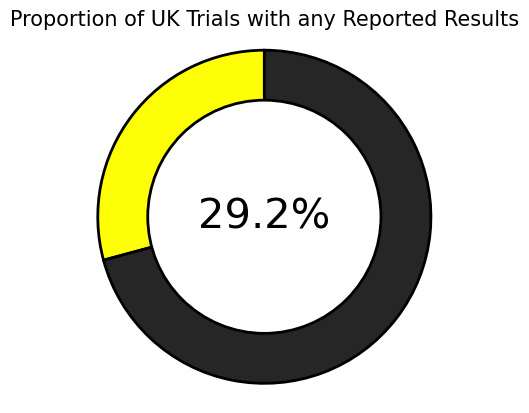

In [45]:
# Calculate the counts
count_results = uk_filtered['results'].sum()
count_no_results = len(uk_filtered) - count_results

# Calculate the proportions
total_trials = len(uk_filtered)
proportion_results = count_results / total_trials
proportion_no_results = count_no_results / total_trials

# Create the donut chart
labels = ['Results Reported', 'Results Not Reported']
sizes = [proportion_results, proportion_no_results]
colors = ['#fefe06', '#262626']
outline_color = '#000000'  # Outline color

plt.pie(sizes, labels=None, colors=colors, startangle=90, wedgeprops={'edgecolor': outline_color, 'linewidth': 2})
plt.title('Proportion of UK Trials with any Reported Results', fontsize=15)

# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white', ec=outline_color, lw=2)  # Add outline to the center circle
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the value of "Results Reported" in the middle of the donut chart
plt.text(0, 0, f'{proportion_results*100:.1f}%', horizontalalignment='center', verticalalignment='center', fontsize=30, color='black')

# Set aspect ratio to be equal so that the pie is drawn as a circle
plt.axis('equal')

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/donut_chart.png', dpi=300)

# Display the chart
plt.show()

## uk_results_2 and race_df

### Create a dataframe that includes the clinical trials that have released results and data on race/ethnicity.

In [46]:
# Merge the two dataframes based on nct_id column
merged_df = uk_results_2.merge(race_df, on='nct_id', how='left')

# Create the race_res_dum column
merged_df['race_res_dum'] = 0  # Initialize the column with 0
merged_df.loc[merged_df['category'].notna(), 'race_res_dum'] = 1  # Set 1 for rows with a match

In [47]:
merged_df.head()

nct_id  start_date                                        brief_title  \
0  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
1  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
2  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
3  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
4  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   

                                      official_title overall_status    phase  \
0  A Phase II, Open-Label, Multi-Centre, Internat...      Completed  Phase 2   
1  A Phase II, Open-Label, Multi-Centre, Internat...      Completed  Phase 2   
2  A Phase II, Open-Label, Multi-Centre, Internat...      Completed  Phase 2   
3  A Phase II, Open-Label, Multi-Centre, Internat...      Completed  Phase 2   
4  A Phase II, Open-Label, Multi-Centre, Internat...      Completed  Phase 2   

   enrollment enrollment_type  number_of_arms  results  \
0       117.0          Actual             2.0        1   
1       117.0          Actual             2.0        1   
2       117.0          Actual             2.0        1   
3       117.0          Actual             2.0        1   
4       117.0          Actual             2.0        1   

                 category                title         units  \
0      Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
1      Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
2      Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
3  Not Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   
4  Not Hispanic or Latino  Ethnicity (NIH/OMB)  Participants   

              param_type param_value  race_res_dum  
0  Count of Participants         1.0             1  
1  Count of Participants         0.0             1  
2  Count of Participants         1.0             1  
3  Count of Participants       103.0             1  
4  Count of Participants         3.0             1

In [48]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71967 entries, 0 to 71966
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nct_id           71967 non-null  object 
 1   start_date       71967 non-null  object 
 2   brief_title      71967 non-null  object 
 3   official_title   71853 non-null  object 
 4   overall_status   71967 non-null  object 
 5   phase            71946 non-null  object 
 6   enrollment       71967 non-null  float64
 7   enrollment_type  71967 non-null  object 
 8   number_of_arms   71897 non-null  float64
 9   results          71967 non-null  int64  
 10  category         68784 non-null  object 
 11  title            68784 non-null  object 
 12  units            68784 non-null  object 
 13  param_type       68784 non-null  object 
 14  param_value      68650 non-null  object 
 15  race_res_dum     71967 non-null  int64  
dtypes: float64(2), int64(2), object(12)
memory usage: 9.3+ MB


In [49]:
merged_df['nct_id'].nunique()

5504

In [50]:
merged_df.to_csv('uk_trials_results_all.csv')

In [51]:
# to be used in the approved_drugs_uk notebook
merged_df1 = merged_df.dropna(subset=['category'])

By dropping nulls in the "category" column, we exclude the trials that did not report the type of race or ethnicity of participants included in the trials and hence cannot be later classified.

In [52]:
merged_df1['param_value'] = merged_df1['param_value'].astype(float)

/tmp/ipykernel_139/452228191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df1['param_value'] = merged_df1['param_value'].astype(float)


In [53]:
merged_df1['nct_id'].nunique()

2321

From the 5504 unique UK clinical trials that released reults, **2321** have released results on race/ethnicity.

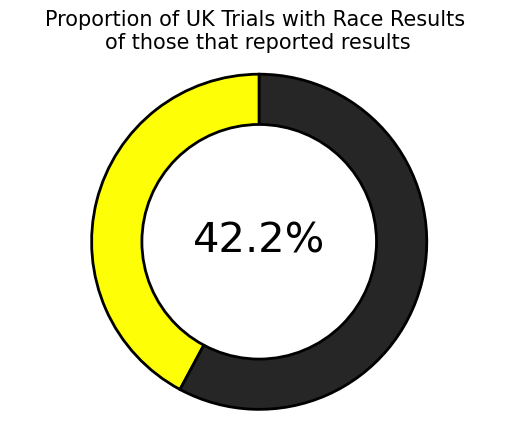

In [54]:
# Count unique nct_id values with race_res_dum
count_race_match = len(merged_df[merged_df['race_res_dum'] == 1]['nct_id'].unique())
count_no_race_match = len(merged_df[merged_df['race_res_dum'] == 0]['nct_id'].unique())

# Calculate the proportions
total_trials = len(merged_df['nct_id'].unique())
proportion_race_match = count_race_match / total_trials
proportion_no_race_match = count_no_race_match / total_trials

# Create the donut chart
labels = ['Race Match', 'No Race Match']
sizes = [proportion_race_match, proportion_no_race_match]
colors = ['#fefe06', '#262626']
outline_color = '#000000'  # Outline color

# Highlight the "Race Match" section with a different color
colors_highlight = ['#fefe06', '#262626']

plt.pie(sizes, labels=None, colors=colors_highlight, startangle=90, wedgeprops={'edgecolor': outline_color, 'linewidth': 2})
plt.title('Proportion of UK Trials with Race Results \nof those that reported results', fontsize=15)

# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white', ec=outline_color, lw=2)  # Add outline to the center circle
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the value of "Race Match" outside the donut chart
plt.text(0, 0, f'{proportion_race_match*100:.1f}%', horizontalalignment='center', verticalalignment='center', fontsize=30, color='black')

# Set aspect ratio to be equal so that the pie is drawn as a circle
plt.axis('equal')

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/race_match_donut_chart.png', dpi=300)

# Display the chart
plt.show()


In [55]:
merged_df1.to_csv('merged.csv')

In [56]:
grouped_df = merged_df1.groupby(['nct_id', 'start_date', 'overall_status', 'phase', 'enrollment_type' , 'category', 'title', 'units', 'param_type']).sum()

/tmp/ipykernel_139/921626668.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = merged_df1.groupby(['nct_id', 'start_date', 'overall_status', 'phase', 'enrollment_type' , 'category', 'title', 'units', 'param_type']).sum()


In [57]:
grouped_df.to_csv('grouped.csv')

In [58]:
grouped_df.reset_index(inplace=True)

In [59]:
grouped_df.nct_id.nunique()

2320

In [60]:
grouped_df.category.nunique()

450

By reading the saved grouped.csv, we will have a better version to work with (no merged rows).
Also, using OpenAI API, I used the Chat GPT Google Docs extension and classified the "category" column into 6 different Race/Erhnicity groups (White, Black, Hispanic/ Latino, Asian, American Indian, Other/Multi) using the following prompt:

*=GPT_CLASSIFY(cell,"White/ White Heritage, Black/ Black Heritage, Hispanic/ Latino, Asian/ Asian Heritage, American Indian/ Alaska Native, Middle Eastern, Hawaiian/ Other Pacific Islander, Other, Mixed, Unknown or Not Reported")*


Some limitations:
- An input category called "other/mixed" was classified as "Other".
- there is a category called “unknown or not reported” and “missing” which is classified as “Unknown or Not collected” --> these are included in the ethnicity/race distributions of clinical trials reported results along with the other races that participated in the trial.

In [61]:
category_counts = grouped_df["category"].value_counts().reset_index()
category_counts.columns = ["category", "frequency"]

category_counts.to_csv("category_frequencies.csv", index=False)

In [125]:
df = pd.read_csv('https://raw.githubusercontent.com/AndreasPetrou/UCL_dissertation.github.io/main/UK%20trials%20(including%20other%20countries)/grouped_race.csv')

In [126]:
df.head()

nct_id  start_date overall_status    phase enrollment_type  \
0  NCT00056550  31/12/2002      Completed  Phase 3          Actual   
1  NCT00056550  31/12/2002      Completed  Phase 3          Actual   
2  NCT00056550  31/12/2002      Completed  Phase 3          Actual   
3  NCT00056550  31/12/2002      Completed  Phase 3          Actual   
4  NCT00056550  31/12/2002      Completed  Phase 3          Actual   

                                    category  \
0           American Indian or Alaska Native   
1                                      Asian   
2                  Black or African American   
3                         More than one race   
4  Native Hawaiian or Other Pacific Islander   

                     race/ethnicity           title         units  \
0    American Indian/ Alaska Native  Race (NIH/OMB)  Participants   
1             Asian/ Asian Heritage  Race (NIH/OMB)  Participants   
2             Black/ Black Heritage  Race (NIH/OMB)  Participants   
3                             Mixed  Race (NIH/OMB)  Participants   
4  Hawaiian/ Other Pacific Islander  Race (NIH/OMB)  Participants   

              param_type  enrollment  number_of_arms  results  param_value  \
0  Count of Participants          14               1        1            0   
1  Count of Participants          14               1        1            0   
2  Count of Participants          14               1        1            0   
3  Count of Participants          14               1        1            0   
4  Count of Participants          14               1        1            0   

   race_res_dum  
0             1  
1             1  
2             1  
3             1  
4             1

In [127]:
df.drop(['category','title','units','param_type'], axis =1 , inplace=True)

In [128]:
# pivot the dataframe to create new columns for each category of the 'race' column
pivoted_df = df.pivot_table(index=['nct_id', 'phase', 'start_date','enrollment_type'], columns='race/ethnicity', values=['param_value'], aggfunc='sum').reset_index()

In [129]:
pivoted_df.head()

nct_id           phase  start_date enrollment_type  \
race/ethnicity                                                            
0               NCT00056550         Phase 3  31/12/2002          Actual   
1               NCT00094328         Phase 2  22/11/2004          Actual   
2               NCT00116753         Phase 2  31/01/2005          Actual   
3               NCT00129987  Not Applicable  30/11/2003          Actual   
4               NCT00135226         Phase 4  31/03/2005          Actual   

                                  param_value                        \
race/ethnicity American Indian/ Alaska Native Asian/ Asian Heritage   
0                                         0.0                   0.0   
1                                         NaN                   3.0   
2                                         4.0                   8.0   
3                                         0.0                 182.0   
4                                         NaN                   NaN   

                                                                       \
race/ethnicity Black/ Black Heritage Hawaiian/ Other Pacific Islander   
0                                0.0                              0.0   
1                                2.0                              NaN   
2                               64.0                              2.0   
3                               92.0                              0.0   
4                              280.0                              NaN   

                                                            \
race/ethnicity Hispanic/ Latino Middle Eastern Mixed Other   
0                           NaN            NaN   0.0   NaN   
1                           1.0            NaN   NaN   1.0   
2                           NaN            NaN   0.0   NaN   
3                           NaN            NaN  28.0   NaN   
4                           NaN          368.0   NaN   NaN   

                                                              
race/ethnicity Unknown or Not Reported White/ White Heritage  
0                                  1.0                  13.0  
1                                  9.0                  12.0  
2                                  0.0                 816.0  
3                                 24.0                 808.0  
4                                442.0               29870.0

In [130]:
pivoted_df.to_csv('grouped_race_trial_2.csv')

I will manually now in excel rename the columns, because now i have 2 rows being the column names.

In [131]:
df_race = pd.read_csv('https://raw.githubusercontent.com/AndreasPetrou/UCL_dissertation.github.io/main/UK%20trials%20(including%20other%20countries)/race_columns.csv')

In [132]:
df_race.head()

nct_id           phase  start_date enrollment_type  \
0  NCT00056550         Phase 3  31/12/2002          Actual   
1  NCT00094328         Phase 2  22/11/2004          Actual   
2  NCT00116753         Phase 2  31/01/2005          Actual   
3  NCT00129987  Not Applicable  30/11/2003          Actual   
4  NCT00135226         Phase 4  31/03/2005          Actual   

   American Indian/ Alaska Native  Asian/ Asian Heritage  \
0                             0.0                    0.0   
1                             NaN                    3.0   
2                             4.0                    8.0   
3                             0.0                  182.0   
4                             NaN                    NaN   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    0.0                               0.0               NaN   
1                    2.0                               NaN               1.0   
2                   64.0                               2.0               NaN   
3                   92.0                               0.0               NaN   
4                  280.0                               NaN               NaN   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             NaN    0.0    NaN                      1.0   
1             NaN    NaN    1.0                      9.0   
2             NaN    0.0    NaN                      0.0   
3             NaN   28.0    NaN                     24.0   
4           368.0    NaN    NaN                    442.0   

   White/ White Heritage  
0                   13.0  
1                   12.0  
2                  816.0  
3                  808.0  
4                29870.0

In [133]:
# create a new column 'uk_races_dum' based on race columns
df_race['uk_races_dum'] = df_race[['Asian/ Asian Heritage','Black/ Black Heritage','Mixed','Other','White/ White Heritage']].apply(lambda x: int(x.notnull().all()), axis=1)

In [134]:
df_race['count'] = 1

In [135]:
df_race.nct_id.nunique()

2320

### Dataframe of Race/Ethnicity and Phase of trial

In [136]:
df_race_phase = df_race.groupby(['phase']).sum()

/tmp/ipykernel_139/2294493066.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_race_phase = df_race.groupby(['phase']).sum()


In [137]:
df_race_phase.reset_index(inplace=True)

In [138]:
df_race_phase

phase  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0    Early Phase 1                             0.0                   12.0   
1   Not Applicable                            64.0                 4711.0   
2          Phase 1                            30.0                 1619.0   
3  Phase 1/Phase 2                            54.0                 1468.0   
4          Phase 2                           858.0                16468.0   
5  Phase 2/Phase 3                           116.0                 3569.0   
6          Phase 3                         20179.0               259038.0   
7          Phase 4                          2176.0                 8852.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                   19.0                               0.0              11.0   
1                 2092.0                              60.0            2396.0   
2                 1079.0                              41.0             401.0   
3                  805.0                              32.0             926.0   
4                 8430.0                             319.0           11414.0   
5                  850.0                              38.0            3192.0   
6                83175.0                            3120.0          208270.0   
7               387688.0                             193.0           20489.0   

   Middle Eastern    Mixed    Other  Unknown or Not Reported  \
0             0.0      6.0      0.0                     17.0   
1             5.0    245.0    176.0                   3223.0   
2            30.0    193.0    147.0                   1342.0   
3             0.0    188.0     80.0                   3425.0   
4           196.0   1054.0   1120.0                  15227.0   
5             0.0    257.0    157.0                   2857.0   
6          1014.0  22218.0  26158.0                 203117.0   
7           502.0   3831.0   1305.0                  19718.0   

   White/ White Heritage  uk_races_dum  count  
0                  545.0             0      5  
1                47560.0             2    113  
2                27830.0             0    179  
3                33389.0             1    115  
4               273016.0            11    640  
5                41733.0             2     54  
6              2737309.0            28   1113  
7               218821.0             0    101

### Dataframe of Race/Ethnicity and unique Clinical Trial IDs

In [139]:
df_race_trials = df_race.groupby(['nct_id','start_date']).sum()

/tmp/ipykernel_139/3658413480.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_race_trials = df_race.groupby(['nct_id','start_date']).sum()


In [140]:
df_race_trials = df_race_trials.reset_index()

In [141]:
df_race_trials['start_date'] = pd.to_datetime(df_race_trials['start_date'])

/tmp/ipykernel_139/2348154908.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_race_trials['start_date'] = pd.to_datetime(df_race_trials['start_date'])


In [142]:
# extract the year from the datetime column
df_race_trials['year'] = df_race_trials['start_date'].dt.year

In [143]:
df_race_trials.head()

nct_id start_date  American Indian/ Alaska Native  \
0  NCT00056550 2002-12-31                             0.0   
1  NCT00094328 2004-11-22                             0.0   
2  NCT00116753 2005-01-31                             4.0   
3  NCT00129987 2003-11-30                             0.0   
4  NCT00135226 2005-03-31                             0.0   

   Asian/ Asian Heritage  Black/ Black Heritage  \
0                    0.0                    0.0   
1                    3.0                    2.0   
2                    8.0                   64.0   
3                  182.0                   92.0   
4                    0.0                  280.0   

   Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                               0.0               0.0             0.0    0.0   
1                               0.0               1.0             0.0    0.0   
2                               2.0               0.0             0.0    0.0   
3                               0.0               0.0             0.0   28.0   
4                               0.0               0.0           368.0    0.0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  count  \
0    0.0                      1.0                   13.0             0      1   
1    1.0                      9.0                   12.0             0      1   
2    0.0                      0.0                  816.0             0      1   
3    0.0                     24.0                  808.0             0      1   
4    0.0                    442.0                29870.0             0      1   

   year  
0  2002  
1  2004  
2  2005  
3  2003  
4  2005

### Dataframe of Race/Ethnicity and Time

In [144]:
df_race['start_date'] = pd.to_datetime(df_race['start_date'])

/tmp/ipykernel_139/2249627174.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_race['start_date'] = pd.to_datetime(df_race['start_date'])


In [145]:
# extract the year from the datetime column
df_race['year'] = df_race['start_date'].dt.year

In [146]:
df_race_time = df_race.groupby(['year']).sum()

/tmp/ipykernel_139/1026857617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_race_time = df_race.groupby(['year']).sum()


In [147]:
df_race_time = df_race_time.reset_index()

In [148]:
df_race_time.head()

year  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0  2002                             0.0                    0.0   
1  2003                             0.0                  185.0   
2  2004                             3.0                    8.0   
3  2005                             8.0                  343.0   
4  2006                           317.0                 7018.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    0.0                               0.0               0.0   
1                  111.0                               0.0               0.0   
2                    8.0                               0.0              64.0   
3                  378.0                               4.0            2546.0   
4                 2328.0                              68.0            7582.0   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             0.0    0.0    0.0                      1.0   
1             0.0   28.0    0.0                     41.0   
2             0.0    0.0    1.0                     41.0   
3           368.0    2.0    7.0                    666.0   
4           314.0   42.0  558.0                    905.0   

   White/ White Heritage  uk_races_dum  count  
0                   13.0             0      1  
1                 1171.0             0      2  
2                 3993.0             0      4  
3                68291.0             0     11  
4                86404.0             0     19

Our final dataframes:
- **df_race_phase**
    - includes the number of participants for each race/ethnicity by each phase of clinical trials
- **df_race_trials**
    - includes the number of participants for each race/ethnicity for each unique clinical trial nct_id
- **df_race_time**
    - includes the number of participants for each race/ethnicity by year

# Visualising the data

Let's first explore the number of new trials with results and the percent of trials reporting any race/ethnicity results by year.

In [149]:
merged_df.nct_id.nunique()

5504

We will work with the above dataframe, since it is the one which includes all the unique clinical trials in the UK that have released results (of any kind).

In [150]:
trial_results = merged_df.copy()

In [151]:
trial_results['start_date'] = pd.to_datetime(trial_results['start_date'])

In [152]:
trial_results = trial_results.groupby(['nct_id','start_date']).sum()

/tmp/ipykernel_139/789453541.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trial_results = trial_results.groupby(['nct_id','start_date']).sum()


In [153]:
trial_results = trial_results.reset_index()

In [154]:
# extract the year from the datetime column
trial_results['year'] = trial_results['start_date'].dt.year

In [155]:
trial_results['nct_id'].nunique()

5504

In [156]:
trial_results.head()

nct_id start_date  enrollment  number_of_arms  results  race_res_dum  \
0  NCT00039871 2002-05-31      2333.0             1.0        1             0   
1  NCT00040664 2002-07-31        69.0             3.0        1             0   
2  NCT00041756 2002-07-31       395.0             5.0        1             0   
3  NCT00046228 2002-08-31      2461.0             3.0        1             0   
4  NCT00048048 2002-03-31        65.0             9.0        1             0   

   year  
0  2002  
1  2002  
2  2002  
3  2002  
4  2002

In [157]:
trial_results.drop(['enrollment','number_of_arms','results'], axis=1, inplace=True)

In [158]:
trial_results.head()

nct_id start_date  race_res_dum  year
0  NCT00039871 2002-05-31             0  2002
1  NCT00040664 2002-07-31             0  2002
2  NCT00041756 2002-07-31             0  2002
3  NCT00046228 2002-08-31             0  2002
4  NCT00048048 2002-03-31             0  2002

In [159]:
trial_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   nct_id        5504 non-null   object        
 1   start_date    5504 non-null   datetime64[ns]
 2   race_res_dum  5504 non-null   int64         
 3   year          5504 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 172.1+ KB


In [160]:
trial_results.nct_id.nunique()

5504

We got 5504 non-null values for nct_id, which means that we have a row for each unique clinical trial.

In [161]:
df_race_trials.head()

nct_id start_date  American Indian/ Alaska Native  \
0  NCT00056550 2002-12-31                             0.0   
1  NCT00094328 2004-11-22                             0.0   
2  NCT00116753 2005-01-31                             4.0   
3  NCT00129987 2003-11-30                             0.0   
4  NCT00135226 2005-03-31                             0.0   

   Asian/ Asian Heritage  Black/ Black Heritage  \
0                    0.0                    0.0   
1                    3.0                    2.0   
2                    8.0                   64.0   
3                  182.0                   92.0   
4                    0.0                  280.0   

   Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                               0.0               0.0             0.0    0.0   
1                               0.0               1.0             0.0    0.0   
2                               2.0               0.0             0.0    0.0   
3                               0.0               0.0             0.0   28.0   
4                               0.0               0.0           368.0    0.0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  count  \
0    0.0                      1.0                   13.0             0      1   
1    1.0                      9.0                   12.0             0      1   
2    0.0                      0.0                  816.0             0      1   
3    0.0                     24.0                  808.0             0      1   
4    0.0                    442.0                29870.0             0      1   

   year  
0  2002  
1  2004  
2  2005  
3  2003  
4  2005

The above dataframe includes all the clinical trials that released race/ethnicity results (2320 trials).

In [162]:
trial_results_race = pd.merge(trial_results, df_race_trials, on='nct_id', how='outer')

In [163]:
trial_results_race.head()

nct_id start_date_x  race_res_dum  year_x start_date_y  \
0  NCT00039871   2002-05-31             0    2002          NaT   
1  NCT00040664   2002-07-31             0    2002          NaT   
2  NCT00041756   2002-07-31             0    2002          NaT   
3  NCT00046228   2002-08-31             0    2002          NaT   
4  NCT00048048   2002-03-31             0    2002          NaT   

   American Indian/ Alaska Native  Asian/ Asian Heritage  \
0                             NaN                    NaN   
1                             NaN                    NaN   
2                             NaN                    NaN   
3                             NaN                    NaN   
4                             NaN                    NaN   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    NaN                               NaN               NaN   
1                    NaN                               NaN               NaN   
2                    NaN                               NaN               NaN   
3                    NaN                               NaN               NaN   
4                    NaN                               NaN               NaN   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             NaN    NaN    NaN                      NaN   
1             NaN    NaN    NaN                      NaN   
2             NaN    NaN    NaN                      NaN   
3             NaN    NaN    NaN                      NaN   
4             NaN    NaN    NaN                      NaN   

   White/ White Heritage  uk_races_dum  count  year_y  
0                    NaN           NaN    NaN     NaN  
1                    NaN           NaN    NaN     NaN  
2                    NaN           NaN    NaN     NaN  
3                    NaN           NaN    NaN     NaN  
4                    NaN           NaN    NaN     NaN

In [164]:
# rename the 'year_y' column to 'race_dum' and convert nulls to 0 and non-nulls to 1
trial_results_race.rename(columns={'year_y': 'race_dum'}, inplace=True)
trial_results_race['race_dum'] = trial_results_race['race_dum'].notnull().astype(int)

In [165]:
trial_results_race.drop(['count'], axis=1, inplace=True)

In [166]:
trial_results_race['number of new trials with results'] = 1

In [167]:
trial_results_race

nct_id start_date_x  race_res_dum  year_x start_date_y  \
0     NCT00039871   2002-05-31             0    2002          NaT   
1     NCT00040664   2002-07-31             0    2002          NaT   
2     NCT00041756   2002-07-31             0    2002          NaT   
3     NCT00046228   2002-08-31             0    2002          NaT   
4     NCT00048048   2002-03-31             0    2002          NaT   
...           ...          ...           ...     ...          ...   
5499  NCT04997161   2021-08-17             7    2021   2021-08-17   
5500  NCT05176717   2021-12-15            40    2021   2021-12-15   
5501  NCT05288673   2015-07-28             0    2015          NaT   
5502  NCT05288829   2016-08-19            12    2016   2016-08-19   
5503  NCT05313412   2022-01-27             0    2022          NaT   

      American Indian/ Alaska Native  Asian/ Asian Heritage  \
0                                NaN                    NaN   
1                                NaN                    NaN   
2                                NaN                    NaN   
3                                NaN                    NaN   
4                                NaN                    NaN   
...                              ...                    ...   
5499                             0.0                    0.0   
5500                             0.0                    0.0   
5501                             NaN                    NaN   
5502                             0.0                    0.0   
5503                             NaN                    NaN   

      Black/ Black Heritage  Hawaiian/ Other Pacific Islander  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       NaN                               NaN   
4                       NaN                               NaN   
...                     ...                               ...   
5499                    0.0                               0.0   
5500                    0.0                               0.0   
5501                    NaN                               NaN   
5502                    0.0                               0.0   
5503                    NaN                               NaN   

      Hispanic/ Latino  Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0                  NaN             NaN    NaN    NaN                      NaN   
1                  NaN             NaN    NaN    NaN                      NaN   
2                  NaN             NaN    NaN    NaN                      NaN   
3                  NaN             NaN    NaN    NaN                      NaN   
4                  NaN             NaN    NaN    NaN                      NaN   
...                ...             ...    ...    ...                      ...   
5499               0.0             0.0    0.0    0.0                      0.0   
5500               2.0             0.0    0.0    0.0                      0.0   
5501               NaN             NaN    NaN    NaN                      NaN   
5502               4.0             0.0    0.0    0.0                      0.0   
5503               NaN             NaN    NaN    NaN                      NaN   

      White/ White Heritage  uk_races_dum  race_dum  \
0                       NaN           NaN         0   
1                       NaN           NaN         0   
2                       NaN           NaN         0   
3                       NaN           NaN         0   
4                       NaN           NaN         0   
...                     ...           ...       ...   
5499                    0.0           0.0         1   
5500                   18.0           0.0         1   
5501                    NaN           NaN         0   
5502                   80.0           0.0         1   
5503                    NaN           NaN         0   

      numb

In [168]:
trial_results_race.to_csv('trial_results_race.csv')

In [169]:
trial_results_race_year = trial_results_race.groupby(['year_x']).sum().reset_index()

/tmp/ipykernel_139/3648735719.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trial_results_race_year = trial_results_race.groupby(['year_x']).sum().reset_index()


In [170]:
trial_results_race_year.rename(columns={'year_x': 'year'}, inplace=True)

In [171]:
trial_results_race_year

year  race_res_dum  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0   2002             7                             0.0                    0.0   
1   2003            28                             0.0                  185.0   
2   2004            33                             3.0                    8.0   
3   2005           250                             8.0                  343.0   
4   2006           538                           317.0                 7018.0   
5   2007           565                           463.0                 9902.0   
6   2008           785                           508.0                12888.0   
7   2009          1563                           219.0                10074.0   
8   2010          2064                          1408.0                18547.0   
9   2011          2387                          2916.0                23273.0   
10  2012          3838                          1782.0                16346.0   
11  2013          5370                          2346.0                41817.0   
12  2014          6445                           679.0                22290.0   
13  2015         11178                          3778.0                41827.0   
14  2016         10415                          2222.0                26844.0   
15  2017          9215                          3259.0                34940.0   
16  2018          7953                          1202.0                16748.0   
17  2019          3743                           948.0                 6928.0   
18  2020          2137                          1353.0                 5741.0   
19  2021           270                            66.0                   18.0   
20  2022             0                             0.0                    0.0   

    Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                     0.0                               0.0               0.0   
1                   111.0                               0.0               0.0   
2                     8.0                               0.0              64.0   
3                   378.0                               4.0            2546.0   
4                  2328.0                              68.0            7582.0   
5                  2412.0                              22.0            1217.0   
6                  2131.0                              45.0            1252.0   
7                  2472.0                              76.0            2233.0   
8                  7582.0                             224.0           15594.0   
9                  5124.0                             157.0            4196.0   
10                 4403.0                             127.0           21905.0   
11                15549.0                             420.0           46691.0   
12               386638.0                             690.0           19996.0   
13                14138.0                             399.0           27710.0   
14                11862.0                             596.0           21722.0   
15                14108.0                             464.0           41049.0   
16                 6785.0                             242.0           12734.0   
17                 2445.0                              67.0            8642.0   
18                 5509.0                             200.0           11649.0   
19                  155.0                               2.0             317.0   
20                    0.0                               0.0               0.0   

    Middle Eastern   Mixed   Other  Unknown or Not Reported  \
0              0.0     0.0     0.0                      1.0   
1              0.0    28.0     0.0                     41.0   
2              0.0     0.0     1.0                     41.0   
3            368.0     2.0     7.0                    666.0   
4            314.0    42.0   558.0                    905.0   
5             32.0  7501.0   466.0                    307.0 

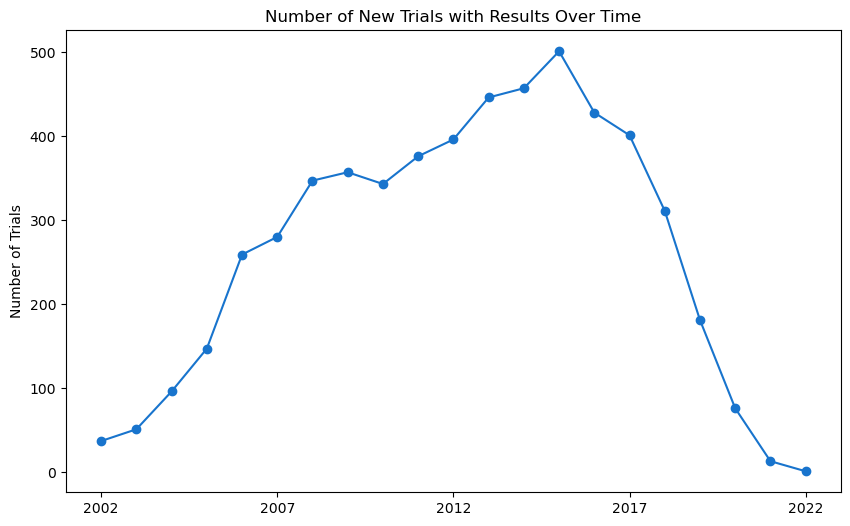

In [172]:
# You can modify the column name accordingly if needed
x = trial_results_race_year['year']
y = trial_results_race_year['number of new trials with results']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line graph
ax.plot(x, y, marker='o', linestyle='-', color='#1874CD')

# Customize the plot
ax.set_title('Number of New Trials with Results Over Time')
ax.set_ylabel('Number of Trials')

# Set x-axis ticks and labels with 5-year intervals
plt.xticks(range(2002, 2023, 5))

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/new_trials_with_results_line.png', dpi=300)

# Display the plot
plt.show()

In [173]:
def calculate_percent_reporting_race(df):
    df['percent of trials reporting any race/ethnicity data'] = round((df['race_dum'] / df['number of new trials with results']) * 100, 2)
    return df

def calculate_percent_reporting_all(df):
    df['percent of trials reporting any race/ethnicity data'] = round((df['race_dum'] / df['number of new trials with results']) * 100, 2)
    df['percent of trials reporting All UK Race Groups'] = round((df['uk_races_dum'] / df['race_dum']) * 100, 2)
    return df

In [174]:
calculate_percent_reporting_race(trial_results_race_year)
calculate_percent_reporting_all(trial_results_race_year)

year  race_res_dum  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0   2002             7                             0.0                    0.0   
1   2003            28                             0.0                  185.0   
2   2004            33                             3.0                    8.0   
3   2005           250                             8.0                  343.0   
4   2006           538                           317.0                 7018.0   
5   2007           565                           463.0                 9902.0   
6   2008           785                           508.0                12888.0   
7   2009          1563                           219.0                10074.0   
8   2010          2064                          1408.0                18547.0   
9   2011          2387                          2916.0                23273.0   
10  2012          3838                          1782.0                16346.0   
11  2013          5370                          2346.0                41817.0   
12  2014          6445                           679.0                22290.0   
13  2015         11178                          3778.0                41827.0   
14  2016         10415                          2222.0                26844.0   
15  2017          9215                          3259.0                34940.0   
16  2018          7953                          1202.0                16748.0   
17  2019          3743                           948.0                 6928.0   
18  2020          2137                          1353.0                 5741.0   
19  2021           270                            66.0                   18.0   
20  2022             0                             0.0                    0.0   

    Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                     0.0                               0.0               0.0   
1                   111.0                               0.0               0.0   
2                     8.0                               0.0              64.0   
3                   378.0                               4.0            2546.0   
4                  2328.0                              68.0            7582.0   
5                  2412.0                              22.0            1217.0   
6                  2131.0                              45.0            1252.0   
7                  2472.0                              76.0            2233.0   
8                  7582.0                             224.0           15594.0   
9                  5124.0                             157.0            4196.0   
10                 4403.0                             127.0           21905.0   
11                15549.0                             420.0           46691.0   
12               386638.0                             690.0           19996.0   
13                14138.0                             399.0           27710.0   
14                11862.0                             596.0           21722.0   
15                14108.0                             464.0           41049.0   
16                 6785.0                             242.0           12734.0   
17                 2445.0                              67.0            8642.0   
18                 5509.0                             200.0           11649.0   
19                  155.0                               2.0             317.0   
20                    0.0                               0.0               0.0   

    Middle Eastern   Mixed   Other  Unknown or Not Reported  \
0              0.0     0.0     0.0                      1.0   
1              0.0    28.0     0.0                     41.0   
2              0.0     0.0     1.0                     41.0   
3            368.0     2.0     7.0                    666.0   
4            314.0    42.0   558.0                    905.0   
5             32.0  7501.0   466.0                    307.0 

In [175]:
trial_results_race_year.head()

year  race_res_dum  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0  2002             7                             0.0                    0.0   
1  2003            28                             0.0                  185.0   
2  2004            33                             3.0                    8.0   
3  2005           250                             8.0                  343.0   
4  2006           538                           317.0                 7018.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    0.0                               0.0               0.0   
1                  111.0                               0.0               0.0   
2                    8.0                               0.0              64.0   
3                  378.0                               4.0            2546.0   
4                 2328.0                              68.0            7582.0   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             0.0    0.0    0.0                      1.0   
1             0.0   28.0    0.0                     41.0   
2             0.0    0.0    1.0                     41.0   
3           368.0    2.0    7.0                    666.0   
4           314.0   42.0  558.0                    905.0   

   White/ White Heritage  uk_races_dum  race_dum  \
0                   13.0           0.0         1   
1                 1171.0           0.0         2   
2                 3993.0           0.0         4   
3                68291.0           0.0        11   
4                86404.0           0.0        19   

   number of new trials with results  \
0                                 37   
1                                 51   
2                                 96   
3                                147   
4                                259   

   percent of trials reporting any race/ethnicity data  \
0                                               2.70     
1                                               3.92     
2                                               4.17     
3                                               7.48     
4                                               7.34     

   percent of trials reporting All UK Race Groups  
0                                             0.0  
1                                             0.0  
2                                             0.0  
3                                             0.0  
4                                             0.0

In [176]:
table_1 = trial_results_race_year.iloc[:,[0,14,15,16]]

In [177]:
table_1

year  number of new trials with results  \
0   2002                                 37   
1   2003                                 51   
2   2004                                 96   
3   2005                                147   
4   2006                                259   
5   2007                                280   
6   2008                                347   
7   2009                                357   
8   2010                                343   
9   2011                                376   
10  2012                                396   
11  2013                                446   
12  2014                                457   
13  2015                                501   
14  2016                                428   
15  2017                                401   
16  2018                                311   
17  2019                                181   
18  2020                                 76   
19  2021                                 13   
20  2022                                  1   

    percent of trials reporting any race/ethnicity data  \
0                                                2.70     
1                                                3.92     
2                                                4.17     
3                                                7.48     
4                                                7.34     
5                                               10.00     
6                                               11.24     
7                                               19.05     
8                                               23.91     
9                                               24.47     
10                                              31.06     
11                                              39.91     
12                                              52.74     
13                                              68.26     
14                                              72.66     
15                                              78.80     
16                                              77.49     
17                                              80.66     
18                                              84.21     
19                                              92.31     
20                                               0.00     

    percent of trials reporting All UK Race Groups  
0                                             0.00  
1                                             0.00  
2                                             0.00  
3                                             0.00  
4                                             0.00  
5                                             0.00  
6                                             0.00  
7                                             0.00  
8                                             0.00  
9                                             4.35  
10                                            5.69  
11                                            3.93  
12                                            1.66  
13                                            2.63  
14                                            1.61  
15                                            0.95  
16                                            1.66  
17                                            0.00  
18                                            1.56  
19                                            0.00  
20                                             NaN

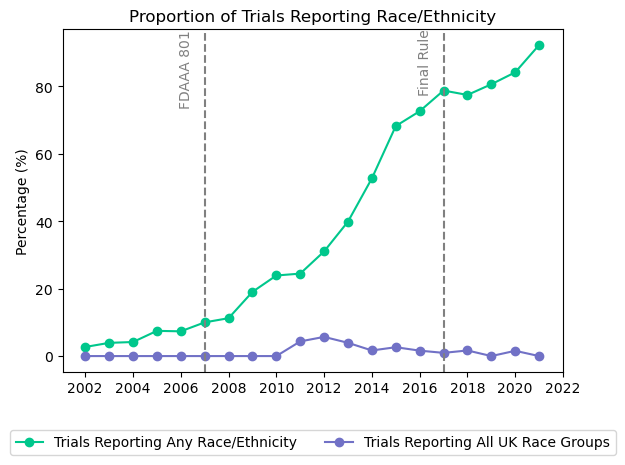

In [178]:
# Filter the data until 2021
table_1_filtered = table_1[table_1['year'] <= 2021]

# Plot the line graphs
plt.plot(table_1_filtered['year'], table_1_filtered['percent of trials reporting any race/ethnicity data'], marker='o', color='#00C78C', label='Trials Reporting Any Race/Ethnicity')
plt.plot(table_1_filtered['year'], table_1_filtered['percent of trials reporting All UK Race Groups'], marker='o', color='#7171C6', label='Trials Reporting All UK Race Groups')

# Set the labels and title
plt.ylabel('Percentage (%)')
plt.title('Proportion of Trials Reporting Race/Ethnicity')

# Set the x-axis tick positions and labels
plt.xticks(range(table_1_filtered['year'].min(), table_1_filtered['year'].max()+2, 2))

# Add vertical dotted lines and labels
plt.axvline(x=2007, linestyle='--', color='gray')
plt.text(2006.5, plt.ylim()[1]*0.9, 'FDAAA 801   ', ha='right', va='center', rotation='vertical', color='gray')

plt.axvline(x=2017, linestyle='--', color='gray')
plt.text(2016.5, plt.ylim()[1]*0.9, 'Final Rule', ha='right', va='center', rotation='vertical', color='gray')

# Move the legend below the graph 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/reporting_line_graph.png', dpi=300)

# Display the plot
plt.show()

In [179]:
trial_results_race_mmyy = trial_results_race.copy()

In [180]:
trial_results_race_mmyy.sort_values(by='start_date_x')

nct_id start_date_x  race_res_dum  year_x start_date_y  \
64    NCT00097786   2002-01-31             0    2002          NaT   
4304  NCT02748213   2002-02-28             0    2002          NaT   
2458  NCT01606137   2002-02-28             0    2002          NaT   
923   NCT00674609   2002-02-28             0    2002          NaT   
2455  NCT01604265   2002-03-31             0    2002          NaT   
...           ...          ...           ...     ...          ...   
5493  NCT04730349   2021-06-03             9    2021   2021-03-06   
5499  NCT04997161   2021-08-17             7    2021   2021-08-17   
5371  NCT04064346   2021-10-28            10    2021   2021-10-28   
5500  NCT05176717   2021-12-15            40    2021   2021-12-15   
5503  NCT05313412   2022-01-27             0    2022          NaT   

      American Indian/ Alaska Native  Asian/ Asian Heritage  \
64                               NaN                    NaN   
4304                             NaN                    NaN   
2458                             NaN                    NaN   
923                              NaN                    NaN   
2455                             NaN                    NaN   
...                              ...                    ...   
5493                             0.0                    0.0   
5499                             0.0                    0.0   
5371                             0.0                    2.0   
5500                             0.0                    0.0   
5503                             NaN                    NaN   

      Black/ Black Heritage  Hawaiian/ Other Pacific Islander  \
64                      NaN                               NaN   
4304                    NaN                               NaN   
2458                    NaN                               NaN   
923                     NaN                               NaN   
2455                    NaN                               NaN   
...                     ...                               ...   
5493                    0.0                               0.0   
5499                    0.0                               0.0   
5371                    1.0                               0.0   
5500                    0.0                               0.0   
5503                    NaN                               NaN   

      Hispanic/ Latino  Middle Eastern  Mixed  Other  Unknown or Not Reported  \
64                 NaN             NaN    NaN    NaN                      NaN   
4304               NaN             NaN    NaN    NaN                      NaN   
2458               NaN             NaN    NaN    NaN                      NaN   
923                NaN             NaN    NaN    NaN                      NaN   
2455               NaN             NaN    NaN    NaN                      NaN   
...                ...             ...    ...    ...                      ...   
5493               2.0             0.0    0.0    0.0                      8.0   
5499               0.0             0.0    0.0    0.0                      0.0   
5371               1.0             0.0    0.0    0.0                      0.0   
5500               2.0             0.0    0.0    0.0                      0.0   
5503               NaN             NaN    NaN    NaN                      NaN   

      White/ White Heritage  uk_races_dum  race_dum  \
64                      NaN           NaN         0   
4304                    NaN           NaN         0   
2458                    NaN           NaN         0   
923                     NaN           NaN         0   
2455                    NaN           NaN         0   
...                     ...           ...       ...   
5493                   20.0           0.0         1   
5499                    0.0           0.0         1   
5371                   20.0           0.0         1   
5500                   18.0           0.0         1   
5503                    NaN           NaN         0   

      numb

In [181]:
# Extract and combine month and year into a single column
trial_results_race_mmyy['month_year'] = trial_results_race_mmyy['start_date_x'].dt.strftime('%B %Y')

In [182]:
trial_results_race_mmyy.head()

nct_id start_date_x  race_res_dum  year_x start_date_y  \
0  NCT00039871   2002-05-31             0    2002          NaT   
1  NCT00040664   2002-07-31             0    2002          NaT   
2  NCT00041756   2002-07-31             0    2002          NaT   
3  NCT00046228   2002-08-31             0    2002          NaT   
4  NCT00048048   2002-03-31             0    2002          NaT   

   American Indian/ Alaska Native  Asian/ Asian Heritage  \
0                             NaN                    NaN   
1                             NaN                    NaN   
2                             NaN                    NaN   
3                             NaN                    NaN   
4                             NaN                    NaN   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    NaN                               NaN               NaN   
1                    NaN                               NaN               NaN   
2                    NaN                               NaN               NaN   
3                    NaN                               NaN               NaN   
4                    NaN                               NaN               NaN   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             NaN    NaN    NaN                      NaN   
1             NaN    NaN    NaN                      NaN   
2             NaN    NaN    NaN                      NaN   
3             NaN    NaN    NaN                      NaN   
4             NaN    NaN    NaN                      NaN   

   White/ White Heritage  uk_races_dum  race_dum  \
0                    NaN           NaN         0   
1                    NaN           NaN         0   
2                    NaN           NaN         0   
3                    NaN           NaN         0   
4                    NaN           NaN         0   

   number of new trials with results   month_year  
0                                  1     May 2002  
1                                  1    July 2002  
2                                  1    July 2002  
3                                  1  August 2002  
4                                  1   March 2002

In [183]:
trial_results_race_mmyy.drop(['start_date_x','year_x','start_date_y'], axis=1, inplace=True)

In [184]:
trial_results_race_mmyy = trial_results_race_mmyy.groupby(['month_year']).sum()

/tmp/ipykernel_139/2200017311.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trial_results_race_mmyy = trial_results_race_mmyy.groupby(['month_year']).sum()


In [185]:
trial_results_race_mmyy = trial_results_race_mmyy.reset_index()

In [186]:
trial_results_race_mmyy.head()

month_year  race_res_dum  American Indian/ Alaska Native  \
0  April 2002             0                             0.0   
1  April 2003             0                             0.0   
2  April 2004             0                             0.0   
3  April 2005             0                             0.0   
4  April 2006           123                            78.0   

   Asian/ Asian Heritage  Black/ Black Heritage  \
0                    0.0                    0.0   
1                    0.0                    0.0   
2                    0.0                    0.0   
3                    0.0                    0.0   
4                 1014.0                 1440.0   

   Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                               0.0               0.0             0.0    0.0   
1                               0.0               0.0             0.0    0.0   
2                               0.0               0.0             0.0    0.0   
3                               0.0               0.0             0.0    0.0   
4                              60.0               0.0             0.0   20.0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  \
0    0.0                      0.0                    0.0           0.0   
1    0.0                      0.0                    0.0           0.0   
2    0.0                      0.0                    0.0           0.0   
3    0.0                      0.0                    0.0           0.0   
4   62.0                    706.0                17214.0           0.0   

   race_dum  number of new trials with results  
0         0                                  3  
1         0                                  1  
2         0                                  3  
3         0                                 10  
4         2                                 18

In [187]:
calculate_percent_reporting_race(trial_results_race_mmyy)
calculate_percent_reporting_all(trial_results_race_mmyy)

month_year  race_res_dum  American Indian/ Alaska Native  \
0        April 2002             0                             0.0   
1        April 2003             0                             0.0   
2        April 2004             0                             0.0   
3        April 2005             0                             0.0   
4        April 2006           123                            78.0   
..              ...           ...                             ...   
230  September 2016           635                           683.0   
231  September 2017           359                            73.0   
232  September 2018           361                           140.0   
233  September 2019           389                           192.0   
234  September 2020           121                            94.0   

     Asian/ Asian Heritage  Black/ Black Heritage  \
0                      0.0                    0.0   
1                      0.0                    0.0   
2                      0.0                    0.0   
3                      0.0                    0.0   
4                   1014.0                 1440.0   
..                     ...                    ...   
230                 6806.0                 4038.0   
231                  338.0                  179.0   
232                 1090.0                  492.0   
233                 1362.0                  341.0   
234                  175.0                  165.0   

     Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  \
0                                 0.0               0.0             0.0   
1                                 0.0               0.0             0.0   
2                                 0.0               0.0             0.0   
3                                 0.0               0.0             0.0   
4                                60.0               0.0             0.0   
..                                ...               ...             ...   
230                             264.0            4086.0           118.0   
231                               7.0             871.0             0.0   
232                              10.0             792.0            14.0   
233                               2.0             122.0             1.0   
234                               2.0             712.0             0.0   

      Mixed  Other  Unknown or Not Reported  White/ White Heritage  \
0       0.0    0.0                      0.0                    0.0   
1       0.0    0.0                      0.0                    0.0   
2       0.0    0.0                      0.0                    0.0   
3       0.0    0.0                      0.0                    0.0   
4      20.0   62.0                    706.0                17214.0   
..      ...    ...                      ...                    ...   
230  1216.0  102.0                   1500.0                53469.0   
231    36.0    0.0                    203.0                 7555.0   
232    30.0   22.0                   4154.0                11648.0   
233    28.0    0.0                     85.0                 5314.0   
234     2.0   38.0                    102.0                 4879.0   

     uk_races_dum  race_dum  number of new trials with results  \
0             0.0         0                                  3   
1             0.0         0                                  1   
2             0.0         0                                  3   
3             0.0         0                                 10   
4             0.0         2                                 18   
..            ...       ...                                ...   
230           0.0        24                                 32   
231           0.0        16                                 24   
232           0.0        15                                 19   
233           0.0        13                                 15   
234           1.0         5                                  8   

     per

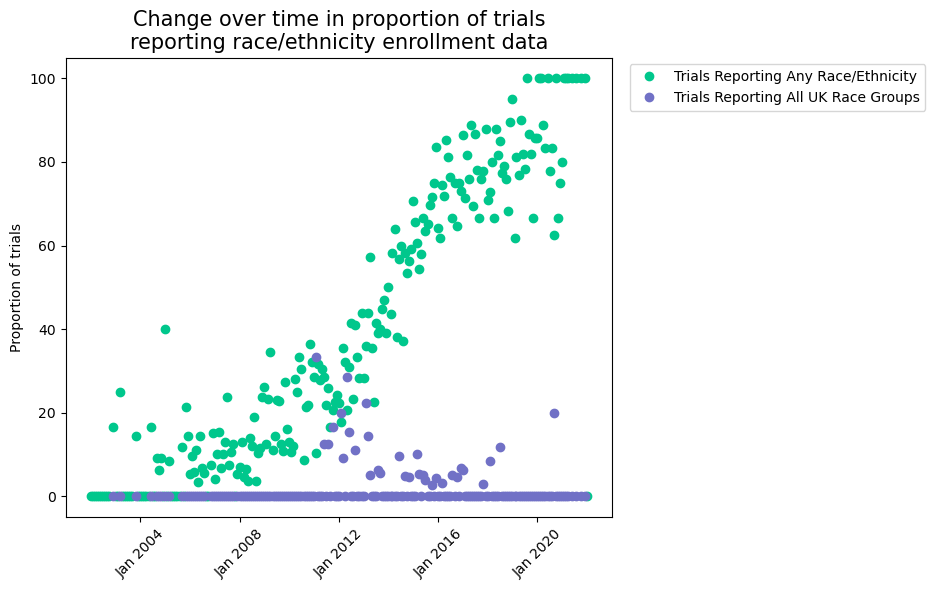

In [188]:
# Convert 'month_year' column to datetime format
trial_results_race_mmyy['month_year'] = pd.to_datetime(trial_results_race_mmyy['month_year'], format='%B %Y')

# Set the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the dot diagrams
ax.plot(trial_results_race_mmyy['month_year'], trial_results_race_mmyy['percent of trials reporting any race/ethnicity data'], 'o', color='#00C78C', label='Trials Reporting Any Race/Ethnicity')
ax.plot(trial_results_race_mmyy['month_year'], trial_results_race_mmyy['percent of trials reporting All UK Race Groups'], 'o', color='#7171C6', label='Trials Reporting All UK Race Groups')

# Set the labels and title
# ax.set_xlabel('Month and Year')
ax.set_ylabel('Proportion of trials')

# Add a two-line title
title_line1 = 'Change over time in proportion of trials'
title_line2 = 'reporting race/ethnicity enrollment data'
ax.set_title(f'{title_line1}\n{title_line2}', fontsize=15)

# Add a legend
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Format x-axis ticks to display month and year
date_format = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(date_format)

# Adjust the figure layout to ensure all content is visible
plt.tight_layout(rect=[0, 0, 0.95, 1])  

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/scatter_graphs_reporting.png', dpi=300)

# Display the plot
plt.show()

## Plotting race/ethnicity participation over time by race/ethnicity

In [189]:
df_dummies =  trial_results_race.copy()

# Create dummy variables for race columns
race_columns = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed','Unknown or Not Reported']

# Convert zeros to null for race columns
df_dummies[race_columns] = df_dummies[race_columns].replace(0, np.nan)

# Convert null values to 0 and non-null values to 1 for race columns
df_dummies[race_columns] = df_dummies[race_columns].notnull().astype(int).fillna(0)

df_dummies

nct_id start_date_x  race_res_dum  year_x start_date_y  \
0     NCT00039871   2002-05-31             0    2002          NaT   
1     NCT00040664   2002-07-31             0    2002          NaT   
2     NCT00041756   2002-07-31             0    2002          NaT   
3     NCT00046228   2002-08-31             0    2002          NaT   
4     NCT00048048   2002-03-31             0    2002          NaT   
...           ...          ...           ...     ...          ...   
5499  NCT04997161   2021-08-17             7    2021   2021-08-17   
5500  NCT05176717   2021-12-15            40    2021   2021-12-15   
5501  NCT05288673   2015-07-28             0    2015          NaT   
5502  NCT05288829   2016-08-19            12    2016   2016-08-19   
5503  NCT05313412   2022-01-27             0    2022          NaT   

      American Indian/ Alaska Native  Asian/ Asian Heritage  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   
...                              ...                    ...   
5499                               0                      0   
5500                               0                      0   
5501                               0                      0   
5502                               0                      0   
5503                               0                      0   

      Black/ Black Heritage  Hawaiian/ Other Pacific Islander  \
0                         0                                 0   
1                         0                                 0   
2                         0                                 0   
3                         0                                 0   
4                         0                                 0   
...                     ...                               ...   
5499                      0                                 0   
5500                      0                                 0   
5501                      0                                 0   
5502                      0                                 0   
5503                      0                                 0   

      Hispanic/ Latino  Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0                    0               0      0      0                        0   
1                    0               0      0      0                        0   
2                    0               0      0      0                        0   
3                    0               0      0      0                        0   
4                    0               0      0      0                        0   
...                ...             ...    ...    ...                      ...   
5499                 0               0      0      0                        0   
5500                 1               0      0      0                        0   
5501                 0               0      0      0                        0   
5502                 1               0      0      0                        0   
5503                 0               0      0      0                        0   

      White/ White Heritage  uk_races_dum  race_dum  \
0                         0           NaN         0   
1                         0           NaN         0   
2                         0           NaN         0   
3                         0           NaN         0   
4                         0           NaN         0   
...                     ...           ...       ...   
5499                      0           0.0         1   
5500                      1           0.0         1   
5501                      0           NaN         0   
5502                      1           0.0         1   
5503                      0           NaN         0   

      numb

In [190]:
df_dummies['month_year'] = df_dummies['start_date_x'].dt.strftime('%B %Y')
df_dummies = df_dummies.groupby(['month_year']).sum()
df_dummies.reset_index()

/tmp/ipykernel_139/1909728300.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dummies = df_dummies.groupby(['month_year']).sum()


month_year  race_res_dum  year_x  American Indian/ Alaska Native  \
0        April 2002             0    6006                               0   
1        April 2003             0    2003                               0   
2        April 2004             0    6012                               0   
3        April 2005             0   20050                               0   
4        April 2006           123   36108                               1   
..              ...           ...     ...                             ...   
230  September 2016           635   64512                               8   
231  September 2017           359   48408                               4   
232  September 2018           361   38342                               5   
233  September 2019           389   30285                               5   
234  September 2020           121   16160                               3   

     Asian/ Asian Heritage  Black/ Black Heritage  \
0                        0                      0   
1                        0                      0   
2                        0                      0   
3                        0                      0   
4                        2                      2   
..                     ...                    ...   
230                     21                     20   
231                      9                     10   
232                     10                     11   
233                     10                     10   
234                      4                      4   

     Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  \
0                                   0                 0               0   
1                                   0                 0               0   
2                                   0                 0               0   
3                                   0                 0               0   
4                                   1                 0               0   
..                                ...               ...             ...   
230                                 8                18               2   
231                                 2                12               0   
232                                 3                 9               2   
233                                 1                 5               1   
234                                 1                 4               0   

     Mixed  Other  Unknown or Not Reported  White/ White Heritage  \
0        0      0                        0                      0   
1        0      0                        0                      0   
2        0      0                        0                      0   
3        0      0                        0                      0   
4        1      1                        1                      2   
..     ...    ...                      ...                    ...   
230      8      4                       15                     24   
231      4      0                       11                     16   
232      7      3                       11                     15   
233      4      0                        7                     13   
234      1      2                        5                      5   

     uk_races_dum  race_dum  number of new trials with results  
0             0.0         0                                  3  
1             0.0         0                                  1  
2             0.0         0                                  3  
3             0.0         0                                 10  
4             0.0         2                                 18  
..            ...       ...                                ...  
230           0.0        24                                 32  
231           0.0        16                                 24  
232           0.0        15                                 19  
233           0.0        13                                 15  
23

In [191]:
# Calculate the proportion of trials reporting each ethnicity over time
ethnicity_columns = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']
for race in ethnicity_columns:
    df_dummies[race + '_ratio'] = round((df_dummies[race] / df_dummies['number of new trials with results'])*100,2)

In [192]:
df_dummies.drop(['year_x'], axis=1,inplace=True)

In [193]:
df_dummies.sort_values(by='month_year')

race_res_dum  American Indian/ Alaska Native  \
month_year                                                     
April 2002                 0                               0   
April 2003                 0                               0   
April 2004                 0                               0   
April 2005                 0                               0   
April 2006               123                               1   
...                      ...                             ...   
September 2016           635                               8   
September 2017           359                               4   
September 2018           361                               5   
September 2019           389                               5   
September 2020           121                               3   

                Asian/ Asian Heritage  Black/ Black Heritage  \
month_year                                                     
April 2002                          0                      0   
April 2003                          0                      0   
April 2004                          0                      0   
April 2005                          0                      0   
April 2006                          2                      2   
...                               ...                    ...   
September 2016                     21                     20   
September 2017                      9                     10   
September 2018                     10                     11   
September 2019                     10                     10   
September 2020                      4                      4   

                Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
month_year                                                           
April 2002                                     0                 0   
April 2003                                     0                 0   
April 2004                                     0                 0   
April 2005                                     0                 0   
April 2006                                     1                 0   
...                                          ...               ...   
September 2016                                 8                18   
September 2017                                 2                12   
September 2018                                 3                 9   
September 2019                                 1                 5   
September 2020                                 1                 4   

                Middle Eastern  Mixed  Other  Unknown or Not Reported  ...  \
month_year                                                             ...   
April 2002                   0      0      0                        0  ...   
April 2003                   0      0      0                        0  ...   
April 2004                   0      0      0                        0  ...   
April 2005                   0      0      0                        0  ...   
April 2006                   0      1      1                        1  ...   
...                        ...    ...    ...                      ...  ...   
September 2016               2      8      4                       15  ...   
September 2017               0      4      0                       11  ...   
September 2018               2      7      3                       11  ...   
September 2019               1      4      0                        7  ...   
September 2020               0      1      2                        5  ...   

                number of new trials with results  \
month_year                                          
April 2002                                      3   
April 2003                                      1   
April 2004                                      3   
April 2005                                     10   
April 2006                                     18   
...                                           ...   


In [194]:
df_dummies.reset_index(inplace=True)

In [195]:
# Convert 'month_year' column to datetime object
df_dummies['month_year'] = pd.to_datetime(df_dummies['month_year'])

# Sort the DataFrame by 'month_year'
df_dummies = df_dummies.sort_values('month_year')

In [196]:
df_dummies

month_year  race_res_dum  American Indian/ Alaska Native  \
80  2002-01-01             0                               0   
60  2002-02-01             0                               0   
140 2002-03-01             0                               0   
0   2002-04-01             0                               0   
160 2002-05-01             0                               0   
..         ...           ...                             ...   
139 2021-06-01             9                               0   
39  2021-08-01             7                               0   
215 2021-10-01            10                               0   
59  2021-12-01            40                               0   
100 2022-01-01             0                               0   

     Asian/ Asian Heritage  Black/ Black Heritage  \
80                       0                      0   
60                       0                      0   
140                      0                      0   
0                        0                      0   
160                      0                      0   
..                     ...                    ...   
139                      0                      0   
39                       0                      0   
215                      1                      1   
59                       0                      0   
100                      0                      0   

     Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  \
80                                  0                 0               0   
60                                  0                 0               0   
140                                 0                 0               0   
0                                   0                 0               0   
160                                 0                 0               0   
..                                ...               ...             ...   
139                                 0                 1               0   
39                                  0                 0               0   
215                                 0                 1               0   
59                                  0                 1               0   
100                                 0                 0               0   

     Mixed  Other  ...  number of new trials with results  \
80       0      0  ...                                  1   
60       0      0  ...                                  3   
140      0      0  ...                                  3   
0        0      0  ...                                  3   
160      0      0  ...                                  3   
..     ...    ...  ...                                ...   
139      0      0  ...                                  1   
39       0      0  ...                                  1   
215      0      0  ...                                  1   
59       0      0  ...                                  1   
100      0      0  ...                                  1   

     White/ White Heritage_ratio  Black/ Black Heritage_ratio  \
80                           0.0                          0.0   
60                           0.0                          0.0   
140                          0.0                          0.0   
0                            0.0                          0.0   
160                          0.0                          0.0   
..                           ...                          ...   
139                        100.0                          0.0   
39                           0.0                          0.0   
215                        100.0                        100.0   
59                         100.0                          0.0   
100                          0.0                          0.0   

     Hispanic/ Latino_ratio  Asian/ Asian Heritage_ratio  \
80                      0.0                          0.0   
60                      0.0                          0.0   
140

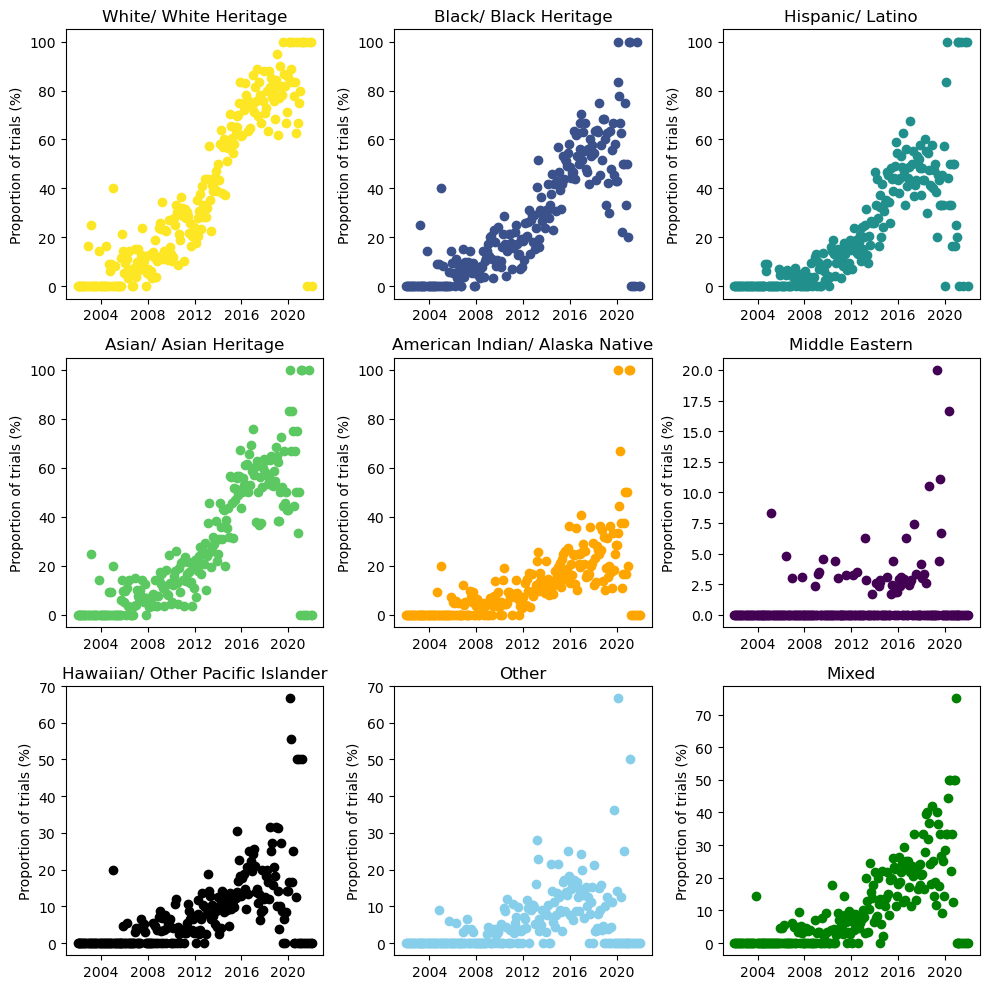

In [197]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flatten()

# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

race_columns = ['White/ White Heritage_ratio','Black/ Black Heritage_ratio','Hispanic/ Latino_ratio','Asian/ Asian Heritage_ratio','American Indian/ Alaska Native_ratio','Middle Eastern_ratio','Hawaiian/ Other Pacific Islander_ratio','Other_ratio','Mixed_ratio']
race_names = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

for i, race in enumerate(race_columns):
    ax = axes[i]
    ax.scatter(df_dummies['month_year'], df_dummies[race], color=colors[i], marker='o')
    ax.set_ylabel('Proportion of trials (%)')
    ax.set_title(race_names[i])

plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/race_proportion_scatter.png', dpi=300)

plt.show()

## Area chart of trilas with results on ethnicity

In [198]:
trial_results_race_year.head()

year  race_res_dum  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0  2002             7                             0.0                    0.0   
1  2003            28                             0.0                  185.0   
2  2004            33                             3.0                    8.0   
3  2005           250                             8.0                  343.0   
4  2006           538                           317.0                 7018.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                    0.0                               0.0               0.0   
1                  111.0                               0.0               0.0   
2                    8.0                               0.0              64.0   
3                  378.0                               4.0            2546.0   
4                 2328.0                              68.0            7582.0   

   Middle Eastern  Mixed  Other  Unknown or Not Reported  \
0             0.0    0.0    0.0                      1.0   
1             0.0   28.0    0.0                     41.0   
2             0.0    0.0    1.0                     41.0   
3           368.0    2.0    7.0                    666.0   
4           314.0   42.0  558.0                    905.0   

   White/ White Heritage  uk_races_dum  race_dum  \
0                   13.0           0.0         1   
1                 1171.0           0.0         2   
2                 3993.0           0.0         4   
3                68291.0           0.0        11   
4                86404.0           0.0        19   

   number of new trials with results  \
0                                 37   
1                                 51   
2                                 96   
3                                147   
4                                259   

   percent of trials reporting any race/ethnicity data  \
0                                               2.70     
1                                               3.92     
2                                               4.17     
3                                               7.48     
4                                               7.34     

   percent of trials reporting All UK Race Groups  
0                                             0.0  
1                                             0.0  
2                                             0.0  
3                                             0.0  
4                                             0.0

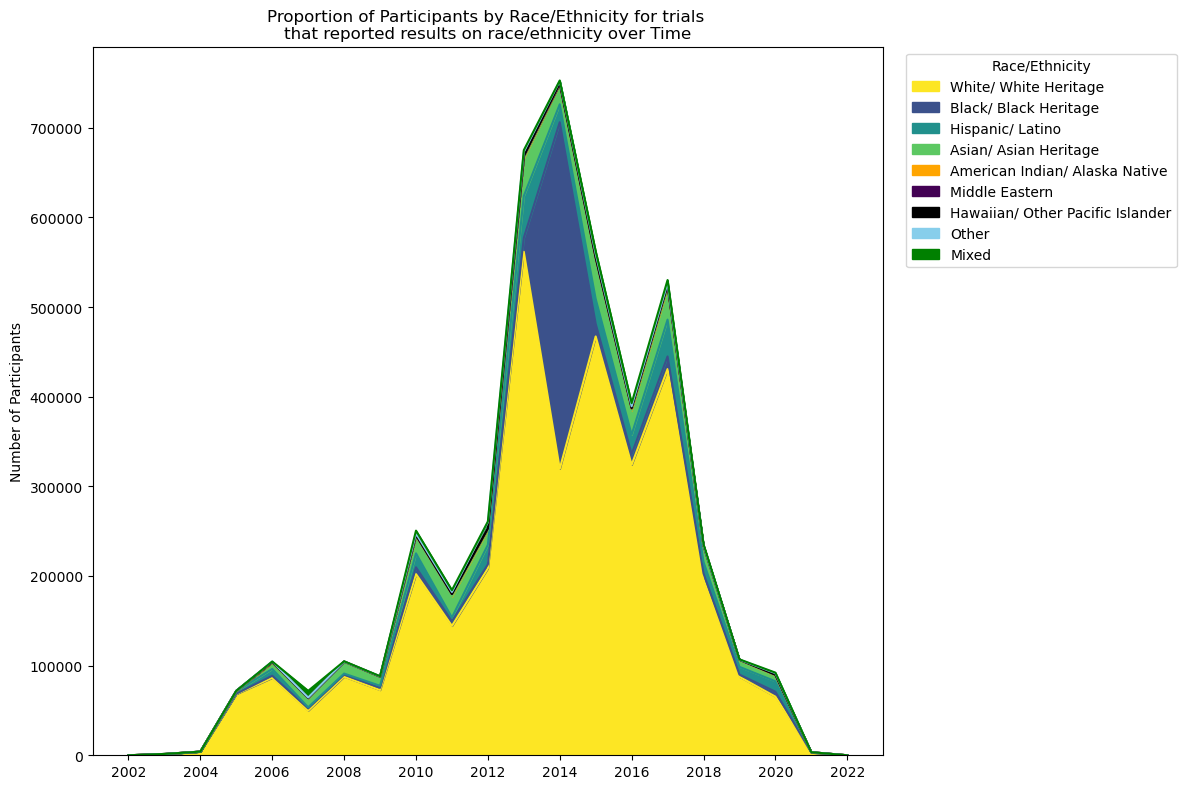

In [199]:
# Selecting the relevant columns for the area chart
columns = ['year', 'White/ White Heritage', 'Black/ Black Heritage', 'Hispanic/ Latino', 'Asian/ Asian Heritage', 'American Indian/ Alaska Native', 'Middle Eastern', 'Hawaiian/ Other Pacific Islander', 'Other', 'Mixed']

# Creating a new dataframe with the selected columns
race_data = trial_results_race_year[columns]

# Setting the 'year' column as the index
race_data.set_index('year', inplace=True)

# Define the colors for each race/ethnicity
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154', 'black', 'skyblue', 'green']

# Set up the figure and axes with larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the area chart with custom colors
race_data.plot.area(stacked=True, color=colors, ax=ax)

# Customizing the plot
plt.title('Proportion of Participants by Race/Ethnicity for trials \nthat reported results on race/ethnicity over Time')
plt.xlabel('')
plt.ylabel('Number of Participants')
plt.legend(title='Race/Ethnicity', bbox_to_anchor=(1.02, 1), loc='upper left')

# Changing x-axis labels
plt.xticks(range(2002, 2023, 2))

# Adjust padding around the figure
plt.tight_layout()

# Save the chart as an image file with higher DPI
plt.savefig('/project/charts_uk_and_other/race_area_chart.png', dpi=600)

# Displaying the chart
plt.show()


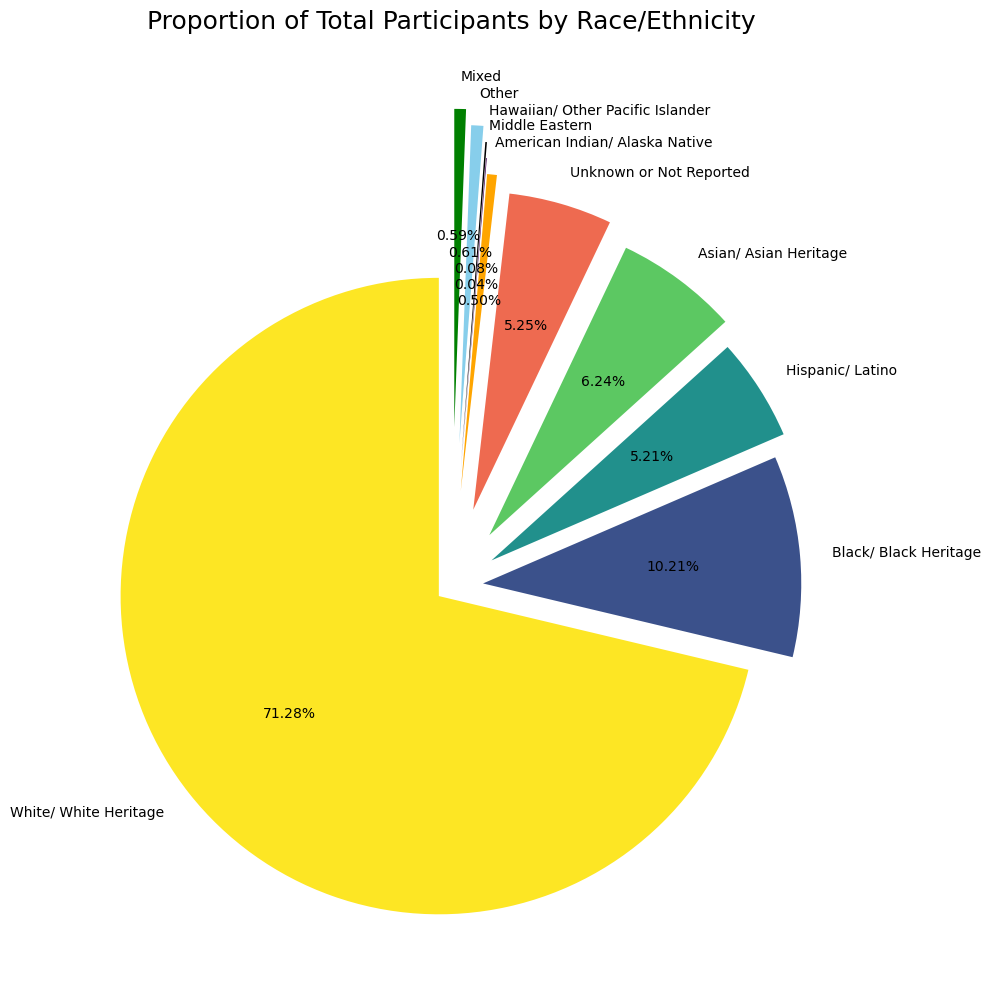

In [200]:
# Calculate the total number of participants by race/ethnicity
total_participants = trial_results_race[['White/ White Heritage', 'Black/ Black Heritage', 'Hispanic/ Latino', 'Asian/ Asian Heritage','Unknown or Not Reported', 'American Indian/ Alaska Native', 'Middle Eastern', 'Hawaiian/ Other Pacific Islander', 'Other', 'Mixed']].sum()

# Define the colors for each race/ethnicity
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', '#EE6A50','orange', '#430154', 'black', 'skyblue', 'green']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Set explode values to break the pie chart
explode = (0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,0.5)

# Plot the pie chart
ax.pie(total_participants, labels=total_participants.index, autopct='%1.2f%%', startangle=90, colors=colors, textprops={'color': 'black'}, explode=explode)

# Set the title
ax.set_title('Proportion of Total Participants by Race/Ethnicity', y=1.19, fontsize=18)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.set_aspect('equal')

# Adjust padding around the figure
plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/participants_pie_chart.png', dpi=300)

# Display the plot
plt.show()


In [201]:
# Calculate the total number of participants by race/ethnicity
total_participants = trial_results_race[['White/ White Heritage', 'Black/ Black Heritage', 'Hispanic/ Latino', 'Asian/ Asian Heritage', 'Unknown or Not Reported', 'American Indian/ Alaska Native', 'Middle Eastern', 'Hawaiian/ Other Pacific Islander', 'Other', 'Mixed']].sum()

# Define the colors for each race/ethnicity
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', '#EE6A50', 'orange', '#430154', 'black', 'skyblue', 'green']

# Create a Pie chart figure
fig = go.Figure(data=[go.Pie(
    labels=total_participants.index,
    values=total_participants,
    textinfo='label+percent',
    hovertemplate='%{label}<br>%{value}<br>%{percent:.1%}',
    marker=dict(colors=colors),
)])

# Set the title
fig.update_layout(
    title='Proportion of Total Participants by Race/Ethnicity',
    title_font_size=18,
)

# Show the interactive chart
fig.show()

## Race/ethnicities that were reported among trials that included any race/ethnicity enrollment results data and the proportion fo those trials that reported each individual race/ethnicity.

In [203]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 80 to 100
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   month_year                              235 non-null    datetime64[ns]
 1   race_res_dum                            235 non-null    int64         
 2   American Indian/ Alaska Native          235 non-null    int64         
 3   Asian/ Asian Heritage                   235 non-null    int64         
 4   Black/ Black Heritage                   235 non-null    int64         
 5   Hawaiian/ Other Pacific Islander        235 non-null    int64         
 6   Hispanic/ Latino                        235 non-null    int64         
 7   Middle Eastern                          235 non-null    int64         
 8   Mixed                                   235 non-null    int64         
 9   Other                                   235 non-null 

In [204]:
df_dummies_2 = df_dummies.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

In [205]:
df_dummies_2 = df_dummies_2[df_dummies_2['race_dum']>0]

In [206]:
df_sum = df_dummies_2.sum()

/tmp/ipykernel_139/2080977414.py:1: FutureWarning:

The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [207]:
df_sum = df_sum.to_frame()

In [208]:
df_sum.reset_index(inplace=True)

In [209]:
# Rename columns using a dictionary
new_columns = {'index': 'Race/Ethnicity', df_sum.columns[-1]: 'Count'}
df_sum = df_sum.rename(columns=new_columns)

In [210]:
df_sum['Proportion of trials'] = round((df_sum['Count']/2321.0)*100,2)

In [211]:
df_sum

Race/Ethnicity    Count  Proportion of trials
0                       race_res_dum  68784.0               2963.55
1     American Indian/ Alaska Native    699.0                 30.12
2              Asian/ Asian Heritage   1655.0                 71.31
3              Black/ Black Heritage   1650.0                 71.09
4   Hawaiian/ Other Pacific Islander    484.0                 20.85
5                   Hispanic/ Latino   1333.0                 57.43
6                     Middle Eastern     51.0                  2.20
7                              Mixed    612.0                 26.37
8                              Other    381.0                 16.42
9            Unknown or Not Reported   1431.0                 61.65
10             White/ White Heritage   2302.0                 99.18
11                      uk_races_dum     44.0                  1.90
12                          race_dum   2320.0                 99.96

In [212]:
df_sum = df_sum.iloc[[1,2,3,4,5,6,7,8,9,10,11]]

In [213]:
df_sum

Race/Ethnicity   Count  Proportion of trials
1     American Indian/ Alaska Native   699.0                 30.12
2              Asian/ Asian Heritage  1655.0                 71.31
3              Black/ Black Heritage  1650.0                 71.09
4   Hawaiian/ Other Pacific Islander   484.0                 20.85
5                   Hispanic/ Latino  1333.0                 57.43
6                     Middle Eastern    51.0                  2.20
7                              Mixed   612.0                 26.37
8                              Other   381.0                 16.42
9            Unknown or Not Reported  1431.0                 61.65
10             White/ White Heritage  2302.0                 99.18
11                      uk_races_dum    44.0                  1.90

In [214]:
# Rename 'uk_races_dum'
df_sum['Race/Ethnicity'] = df_sum['Race/Ethnicity'].replace('uk_races_dum', 'All UK Race Groups')

/tmp/ipykernel_139/1167518604.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



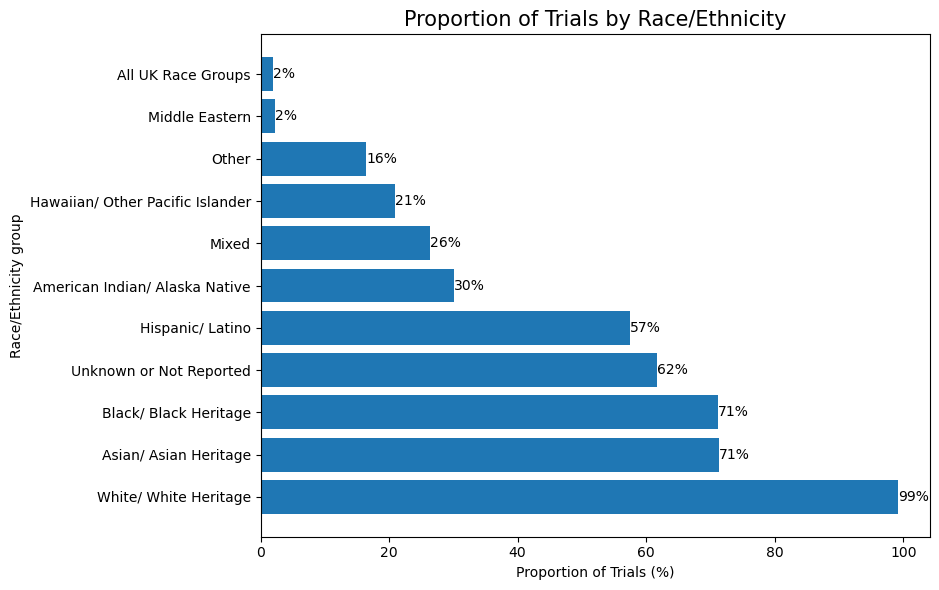

In [215]:
# Sort the DataFrame excluding the "uk_races_dum" row and append it at the end
df_sorted = df_sum[df_sum['Race/Ethnicity'] != 'All UK Race Groups'].sort_values('Proportion of trials', ascending=False)
df_sorted = pd.concat([df_sorted, df_sum[df_sum['Race/Ethnicity'] == 'All UK Race Groups']])

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_sorted['Race/Ethnicity'], df_sorted['Proportion of trials'])

# Add value labels on the right side of the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.0f}%', ha='left', va='center')

# Set the labels and title
ax.set_xlabel('Proportion of Trials (%)')
ax.set_ylabel('Race/Ethnicity group')
ax.set_title('Proportion of Trials by Race/Ethnicity', fontsize=15)

# Adjust the figure layout to ensure all content is visible
plt.tight_layout(rect=[0, 0, 0.95, 1])  

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/bar_chart_all.png', dpi=300)

# Display the plot
plt.show()

## Distribution of trials according to race/ethnicity of enrollees

In [216]:
dist_df = trial_results_race[trial_results_race['uk_races_dum']==1]

In [217]:
dist_df

nct_id start_date_x  race_res_dum  year_x start_date_y  \
1864  NCT01235689   2011-02-11            21    2011   2011-11-02   
1900  NCT01252953   2011-06-30            36    2011   2011-06-30   
2054  NCT01345019   2012-05-17            33    2012   2012-05-17   
2189  NCT01439880   2011-10-07            30    2011   2011-07-10   
2287  NCT01491737   2012-02-17            42    2012   2012-02-17   
2293  NCT01493414   2011-08-16            13    2011   2011-08-16   
2409  NCT01572038   2012-06-01            13    2012   2012-01-06   
2413  NCT01575834   2012-03-15            30    2012   2012-03-15   
2486  NCT01624142   2012-06-01            30    2012   2012-01-06   
2498  NCT01631214   2012-05-04            33    2012   2012-04-05   
2594  NCT01693562   2012-09-05           792    2012   2012-05-09   
2729  NCT01764633   2013-02-08            30    2013   2013-08-02   
2737  NCT01767857   2013-03-31            24    2013   2013-03-31   
2762  NCT01786512   2013-02-26           120    2013   2013-02-26   
2868  NCT01854918   2013-04-23            30    2013   2013-04-23   
2869  NCT01855750   2013-09-03            36    2013   2013-03-09   
2871  NCT01856309   2013-08-07            45    2013   2013-07-08   
3017  NCT01948258   2013-03-01            18    2013   2013-01-03   
3135  NCT02004691   2015-12-18            24    2015   2015-12-18   
3408  NCT02175004   2014-06-26            24    2014   2014-06-26   
3450  NCT02207634   2014-09-10            30    2014   2014-10-09   
3536  NCT02263079   2014-06-16            21    2014   2014-06-16   
3609  NCT02304484   2014-11-24            10    2014   2014-11-24   
3674  NCT02349061   2015-10-15            45    2015   2015-10-15   
3679  NCT02352753   2015-06-24             8    2015   2015-06-24   
3688  NCT02366195   2015-04-07            10    2015   2015-07-04   
3704  NCT02376790   2015-03-03            40    2015   2015-03-03   
3731  NCT02394028   2015-03-20           130    2015   2015-03-20   
3764  NCT02416453   2015-06-15            96    2015   2015-06-15   
3830  NCT02456740   2015-07-17            40    2015   2015-07-17   
3979  NCT02554786   2015-12-29            90    2015   2015-12-29   
4127  NCT02632786   2016-03-31            33    2016   2016-03-31   
4468  NCT02913105   2016-10-24            36    2016   2016-10-24   
4494  NCT02929329   2017-01-06            30    2017   2017-06-01   
4542  NCT02968004   2016-12-31            36    2016   2016-12-31   
4555  NCT02979431   2017-01-11            40    2017   2017-11-01   
4612  NCT03036813   2016-12-31            40    2016   2016-12-31   
4761  NCT03180801   2016-08-18            32    2016   2016-08-18   
4832  NCT03259334   2018-02-09            48    2018   2018-09-02   
4882  NCT03312634   2017-11-30            33    2017   2017-11-30   
4989  NCT03417102   2018-02-14            24    2018   2018-02-14   
5104  NCT03559205   2018-07-10            21    2018   2018-10-07   
5168  NCT03638128   2018-07-26            32    2018   2018-07-26   
5466  NCT04504032   2020-09-02            33    2020   2020-02-09   

      American Indian/ Alaska Native  Asian/ Asian Heritage  \
1864                             0.0                   10.0   
1900                             0.0                17742.0   
2054                             6.0                  416.0   
2189                             8.0                  510.0   
2287                             2.0                  110.0   
2293                             6.0                   25.0   
2409                            49.0                  147.0   
2413                           254.0                 1732.0   
2486                             2.0                   32.0   
2498                            24.0                  572.0   
2594                             0.0                  270.0   
2729                           280.0                 5446.0   
2737                             0.0                   34.0   
2762                   

In [218]:
dist_df = dist_df.iloc[:,[5,6,7,8,9,10,11,12,13,14,15,16]]

In [219]:
dist_df['total participants'] = dist_df.sum(axis=1)

/tmp/ipykernel_139/332937179.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [220]:
# Calculate the proportion of enrollees for each ethnicity
ethnicities = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

# Calculate the proportion of enrollees for each race/ethnicity
for ethnicity in ethnicities:
    dist_df[ethnicity + '_Proportion'] = round(dist_df[ethnicity] / dist_df['total participants'] * 100,2)

/tmp/ipykernel_139/2665245422.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_139/2665245422.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_139/2665245422.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_139/266

In [221]:
dist_df

American Indian/ Alaska Native  Asian/ Asian Heritage  \
1864                             0.0                   10.0   
1900                             0.0                17742.0   
2054                             6.0                  416.0   
2189                             8.0                  510.0   
2287                             2.0                  110.0   
2293                             6.0                   25.0   
2409                            49.0                  147.0   
2413                           254.0                 1732.0   
2486                             2.0                   32.0   
2498                            24.0                  572.0   
2594                             0.0                  270.0   
2729                           280.0                 5446.0   
2737                             0.0                   34.0   
2762                             0.0                    6.0   
2868                            14.0                  880.0   
2869                             6.0                  652.0   
2871                            22.0                  618.0   
3017                             0.0                   14.0   
3135                             0.0                    4.0   
3408                             0.0                    6.0   
3450                             6.0                  118.0   
3536                             0.0                   44.0   
3609                             1.0                   19.0   
3674                             2.0                   56.0   
3679                             0.0                    4.0   
3688                             0.0                    0.0   
3704                            60.0                   10.0   
3731                            10.0                  136.0   
3764                             0.0                   26.0   
3830                             6.0                   34.0   
3979                           136.0                 1932.0   
4127                             0.0                    2.0   
4468                             0.0                   18.0   
4494                           146.0                 1420.0   
4542                             2.0                   90.0   
4555                             0.0                   54.0   
4612                             0.0                    2.0   
4761                             0.0                    8.0   
4832                             0.0                   40.0   
4882                             2.0                   34.0   
4989                             0.0                   78.0   
5104                             0.0                   10.0   
5168                             0.0                    2.0   
5466                             8.0                    2.0   

      Black/ Black Heritage  Hawaiian/ Other Pacific Islander  \
1864                   10.0                               0.0   
1900                  656.0                               0.0   
2054                  130.0                               2.0   
2189                  156.0                              14.0   
2287                   18.0                               0.0   
2293                   20.0                               1.0   
2409                    9.0                               0.0   
2413                  302.0                               2.0   
2486                   12.0                               0.0   
2498                   84.0                               4.0   
2594                   80.0                              10.0   
2729                 1338.0                              52.0   
2737                   56.0                               0.0   
2762                   68.0                               2.0   
2868                  266.0                               8.0   
2869                   16.0                               0.0   
2871                  138.0                               0.0   


In [222]:
dist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1864 to 5466
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   American Indian/ Alaska Native               44 non-null     float64
 1   Asian/ Asian Heritage                        44 non-null     float64
 2   Black/ Black Heritage                        44 non-null     float64
 3   Hawaiian/ Other Pacific Islander             44 non-null     float64
 4   Hispanic/ Latino                             44 non-null     float64
 5   Middle Eastern                               44 non-null     float64
 6   Mixed                                        44 non-null     float64
 7   Other                                        44 non-null     float64
 8   Unknown or Not Reported                      44 non-null     float64
 9   White/ White Heritage                        44 non-null     float64
 10 

In [223]:
dist_df_2 = dist_df.iloc[:,[12,13,14,15,16,17,18,19,20,21]]

In [224]:
dist_df_2.head()

total participants  White/ White Heritage_Proportion  \
1864               490.0                             92.24   
1900            121798.0                             43.02   
2054              6874.0                             88.80   
2189              5298.0                             84.75   
2287              1034.0                             38.10   

      Black/ Black Heritage_Proportion  Hispanic/ Latino_Proportion  \
1864                              2.04                         0.00   
1900                              0.54                         0.39   
2054                              1.89                         2.04   
2189                              2.94                         1.96   
2287                              1.74                        16.44   

      Asian/ Asian Heritage_Proportion  \
1864                              2.04   
1900                             14.57   
2054                              6.05   
2189                              9.63   
2287                             10.64   

      American Indian/ Alaska Native_Proportion  Middle Eastern_Proportion  \
1864                                       0.00                        0.0   
1900                                       0.00                        0.0   
2054                                       0.09                        0.0   
2189                                       0.15                        0.0   
2287                                       0.19                        0.0   

      Hawaiian/ Other Pacific Islander_Proportion  Other_Proportion  \
1864                                         0.00              2.45   
1900                                         0.00              0.16   
2054                                         0.03              0.84   
2189                                         0.26              0.19   
2287                                         0.00             23.79   

      Mixed_Proportion  
1864              0.82  
1900              0.05  
2054              0.03  
2189              0.08  
2287              0.00

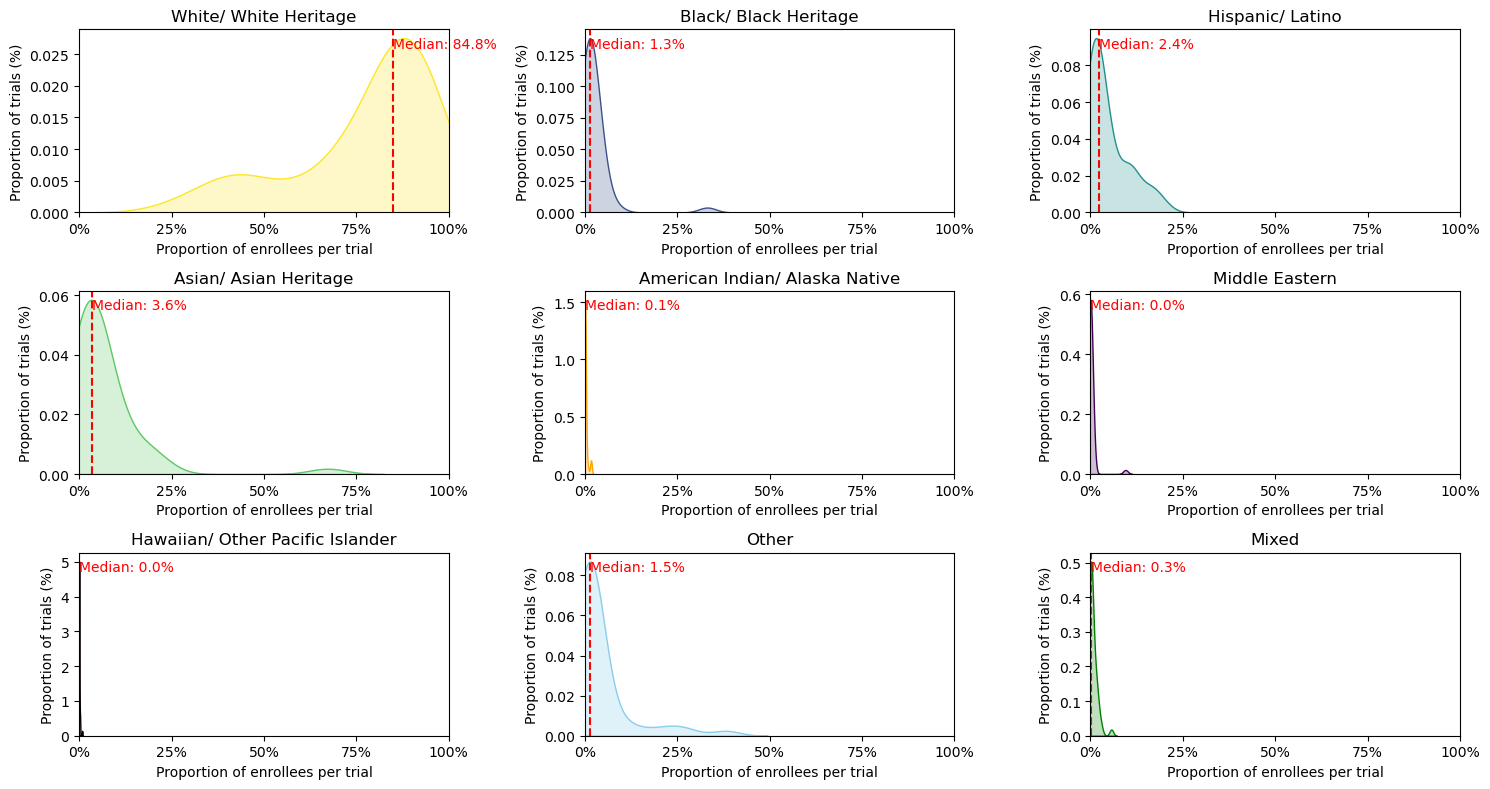

In [225]:
# Define the desired order of columns
columns_to_plot = ['White/ White Heritage_Proportion','Black/ Black Heritage_Proportion','Hispanic/ Latino_Proportion','Asian/ Asian Heritage_Proportion','American Indian/ Alaska Native_Proportion','Middle Eastern_Proportion','Hawaiian/ Other Pacific Islander_Proportion','Other_Proportion','Mixed_Proportion']

# Set the number of columns and rows for subplots
num_columns = 3
num_rows = 3

# Define colors for each graph
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 8))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over each column and plot the line histogram
for i, column in enumerate(columns_to_plot):
    sns.kdeplot(data=dist_df_2[column], ax=axes[i], fill=True, color=colors[i % len(colors)])
    axes[i].set_xlim(0, 100)  # Set x-axis limits to 0-100%
    axes[i].set_ylim(0, None)  # Set y-axis to automatically adjust
    axes[i].set_xlabel('Proportion of enrollees per trial')
    axes[i].set_ylabel('Proportion of trials (%)')
    axes[i].set_title(column.split('_')[0])  # Change the title to each graph

    # Calculate and plot the median line
    median_value = dist_df_2[column].median()
    axes[i].axvline(median_value, color='red', linestyle='--')
    
    # Add text annotation for the median value
    axes[i].text(median_value, axes[i].get_ylim()[1]*0.9, f"Median: {median_value:.1f}%", color='red', ha='left')

    # Set custom x-axis tick positions and labels
    axes[i].set_xticks([0, 25, 50, 75, 100])
    axes[i].set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

# Adjust the spacing between subplots
plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/race_distributions.png', dpi=300)

# Show the plot
plt.show()


## Average number of participants per trial

In [226]:
average_participants = df_race_trials.copy()

In [227]:
df_race_trials

nct_id start_date  American Indian/ Alaska Native  \
0     NCT00056550 2002-12-31                             0.0   
1     NCT00094328 2004-11-22                             0.0   
2     NCT00116753 2005-01-31                             4.0   
3     NCT00129987 2003-11-30                             0.0   
4     NCT00135226 2005-03-31                             0.0   
...           ...        ...                             ...   
2315  NCT04829214 2021-03-22                             2.0   
2316  NCT04884191 2017-07-31                             2.0   
2317  NCT04997161 2021-08-17                             0.0   
2318  NCT05176717 2021-12-15                             0.0   
2319  NCT05288829 2016-08-19                             0.0   

      Asian/ Asian Heritage  Black/ Black Heritage  \
0                       0.0                    0.0   
1                       3.0                    2.0   
2                       8.0                   64.0   
3                     182.0                   92.0   
4                       0.0                  280.0   
...                     ...                    ...   
2315                    2.0                   22.0   
2316                    8.0                   10.0   
2317                    0.0                    0.0   
2318                    0.0                    0.0   
2319                    0.0                    0.0   

      Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  \
0                                  0.0               0.0             0.0   
1                                  0.0               1.0             0.0   
2                                  2.0               0.0             0.0   
3                                  0.0               0.0             0.0   
4                                  0.0               0.0           368.0   
...                                ...               ...             ...   
2315                               0.0              30.0             0.0   
2316                               0.0               0.0             0.0   
2317                               0.0               0.0             0.0   
2318                               0.0               2.0             0.0   
2319                               0.0               4.0             0.0   

      Mixed  Other  Unknown or Not Reported  White/ White Heritage  \
0       0.0    0.0                      1.0                   13.0   
1       0.0    1.0                      9.0                   12.0   
2       0.0    0.0                      0.0                  816.0   
3      28.0    0.0                     24.0                  808.0   
4       0.0    0.0                    442.0                29870.0   
...     ...    ...                      ...                    ...   
2315    0.0    0.0                     16.0                  540.0   
2316    0.0    0.0                     24.0                  278.0   
2317    0.0    0.0                      0.0                    0.0   
2318    0.0    0.0                      0.0                   18.0   
2319    0.0    0.0                      0.0                   80.0   

      uk_races_dum  count  year  
0                0      1  2002  
1                0      1  2004  
2                0      1  2005  
3                0      1  2003  
4                0      1  2005  
...            ...    ...   ...  
2315             0      1  2021  
2316             0      1  2017  
2317             0      1  2021  
2318             0      1  2021  
2319             0      1  2016  

[2320 rows x 15 columns]

In [228]:
average_participants['average_participants'] = average_participants[['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed','Unknown or Not Reported']].sum(axis=1)

In [229]:
average_participants.head()

nct_id start_date  American Indian/ Alaska Native  \
0  NCT00056550 2002-12-31                             0.0   
1  NCT00094328 2004-11-22                             0.0   
2  NCT00116753 2005-01-31                             4.0   
3  NCT00129987 2003-11-30                             0.0   
4  NCT00135226 2005-03-31                             0.0   

   Asian/ Asian Heritage  Black/ Black Heritage  \
0                    0.0                    0.0   
1                    3.0                    2.0   
2                    8.0                   64.0   
3                  182.0                   92.0   
4                    0.0                  280.0   

   Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                               0.0               0.0             0.0    0.0   
1                               0.0               1.0             0.0    0.0   
2                               2.0               0.0             0.0    0.0   
3                               0.0               0.0             0.0   28.0   
4                               0.0               0.0           368.0    0.0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  count  \
0    0.0                      1.0                   13.0             0      1   
1    1.0                      9.0                   12.0             0      1   
2    0.0                      0.0                  816.0             0      1   
3    0.0                     24.0                  808.0             0      1   
4    0.0                    442.0                29870.0             0      1   

   year  average_participants  
0  2002                  14.0  
1  2004                  28.0  
2  2005                 894.0  
3  2003                1134.0  
4  2005               30960.0

In [230]:
print('There are ' + str(int(average_participants.average_participants.mean())) + ' participants per trial.')

There are 2044 participants per trial.


In [231]:
avg_part_year = average_participants.groupby(['year']).sum()

/tmp/ipykernel_139/4199202262.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [232]:
avg_part_year.reset_index(inplace=True)

In [233]:
avg_part_year

year  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0   2002                             0.0                    0.0   
1   2003                             0.0                  185.0   
2   2004                             3.0                    8.0   
3   2005                             8.0                  343.0   
4   2006                           317.0                 7018.0   
5   2007                           463.0                 9902.0   
6   2008                           508.0                12888.0   
7   2009                           219.0                10074.0   
8   2010                          1408.0                18547.0   
9   2011                          2916.0                23273.0   
10  2012                          1782.0                16346.0   
11  2013                          2346.0                41817.0   
12  2014                           679.0                22290.0   
13  2015                          3778.0                41827.0   
14  2016                          2222.0                26844.0   
15  2017                          3259.0                34940.0   
16  2018                          1202.0                16748.0   
17  2019                           948.0                 6928.0   
18  2020                          1353.0                 5741.0   
19  2021                            66.0                   18.0   

    Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                     0.0                               0.0               0.0   
1                   111.0                               0.0               0.0   
2                     8.0                               0.0              64.0   
3                   378.0                               4.0            2546.0   
4                  2328.0                              68.0            7582.0   
5                  2412.0                              22.0            1217.0   
6                  2131.0                              45.0            1252.0   
7                  2472.0                              76.0            2233.0   
8                  7582.0                             224.0           15594.0   
9                  5124.0                             157.0            4196.0   
10                 4403.0                             127.0           21905.0   
11                15549.0                             420.0           46691.0   
12               386638.0                             690.0           19996.0   
13                14138.0                             399.0           27710.0   
14                11862.0                             596.0           21722.0   
15                14108.0                             464.0           41049.0   
16                 6785.0                             242.0           12734.0   
17                 2445.0                              67.0            8642.0   
18                 5509.0                             200.0           11649.0   
19                  155.0                               2.0             317.0   

    Middle Eastern   Mixed   Other  Unknown or Not Reported  \
0              0.0     0.0     0.0                      1.0   
1              0.0    28.0     0.0                     41.0   
2              0.0     0.0     1.0                     41.0   
3            368.0     2.0     7.0                    666.0   
4            314.0    42.0   558.0                    905.0   
5             32.0  7501.0   466.0                    307.0   
6             10.0   260.0     2.0                   2344.0   
7              8.0   179.0   167.0                   5364.0   
8            178.0  3160.0  1800.0                   4479.0   
9              2.0  1954.0  2207.0                  74089.0   
10            48.0   790.0  6827.0                  13973.0   
11            10.0  1875.0  4661.0                  24020.0   
12            17.0   524.0  2350.0                  17708.0   
13          

In [234]:
avg_part_year = avg_part_year.iloc[:,[0,12,13]]

In [235]:
avg_part_year['average participants per trial'] = round(avg_part_year['average_participants']/avg_part_year['count'],0)

/tmp/ipykernel_139/1682114084.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [236]:
avg_part_year

year  count  average_participants  average participants per trial
0   2002      1                  14.0                            14.0
1   2003      2                1536.0                           768.0
2   2004      4                4118.0                          1030.0
3   2005     11               72613.0                          6601.0
4   2006     19              105536.0                          5555.0
5   2007     28               72195.0                          2578.0
6   2008     39              107189.0                          2748.0
7   2009     68               93570.0                          1376.0
8   2010     82              255056.0                          3110.0
9   2011     92              258239.0                          2807.0
10  2012    123              274714.0                          2233.0
11  2013    178              699005.0                          3927.0
12  2014    241              770415.0                          3197.0
13  2015    342              594603.0                          1739.0
14  2016    311              417998.0                          1344.0
15  2017    316              548052.0                          1734.0
16  2018    241              256069.0                          1063.0
17  2019    146              109570.0                           750.0
18  2020     64               98195.0                          1534.0
19  2021     12                3578.0                           298.0

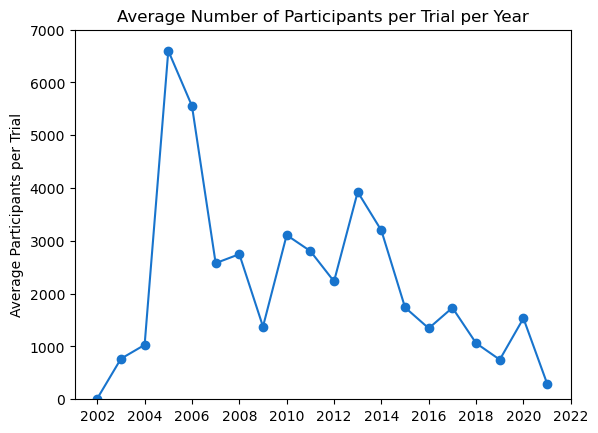

In [237]:
plt.plot(avg_part_year['year'], avg_part_year['average participants per trial'], marker='o', color='#1874CD')

# Set the x-axis tick positions and labels
plt.xticks(range(avg_part_year['year'].min(), avg_part_year['year'].max()+2, 2))

plt.ylabel('Average Participants per Trial')
plt.title('Average Number of Participants per Trial per Year')
plt.grid(False)

# Set the y-axis limit with a small gap at the start
y_start = 0  # Adjust the gap as needed
y_end = 7000  # Change the upper limit as needed
plt.ylim(y_start, y_end)

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/avg_participants_line.png', dpi=300)

plt.show()

## Phases

In [238]:
df_race_phase

phase  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0    Early Phase 1                             0.0                   12.0   
1   Not Applicable                            64.0                 4711.0   
2          Phase 1                            30.0                 1619.0   
3  Phase 1/Phase 2                            54.0                 1468.0   
4          Phase 2                           858.0                16468.0   
5  Phase 2/Phase 3                           116.0                 3569.0   
6          Phase 3                         20179.0               259038.0   
7          Phase 4                          2176.0                 8852.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                   19.0                               0.0              11.0   
1                 2092.0                              60.0            2396.0   
2                 1079.0                              41.0             401.0   
3                  805.0                              32.0             926.0   
4                 8430.0                             319.0           11414.0   
5                  850.0                              38.0            3192.0   
6                83175.0                            3120.0          208270.0   
7               387688.0                             193.0           20489.0   

   Middle Eastern    Mixed    Other  Unknown or Not Reported  \
0             0.0      6.0      0.0                     17.0   
1             5.0    245.0    176.0                   3223.0   
2            30.0    193.0    147.0                   1342.0   
3             0.0    188.0     80.0                   3425.0   
4           196.0   1054.0   1120.0                  15227.0   
5             0.0    257.0    157.0                   2857.0   
6          1014.0  22218.0  26158.0                 203117.0   
7           502.0   3831.0   1305.0                  19718.0   

   White/ White Heritage  uk_races_dum  count  
0                  545.0             0      5  
1                47560.0             2    113  
2                27830.0             0    179  
3                33389.0             1    115  
4               273016.0            11    640  
5                41733.0             2     54  
6              2737309.0            28   1113  
7               218821.0             0    101

In [239]:
df_race_phase_viz = df_race_phase.drop(['uk_races_dum','count'],axis=1)

In [240]:
# Drop the "Not Applicable" row
df_race_phase_viz = df_race_phase_viz[df_race_phase_viz['phase'] != 'Not Applicable']

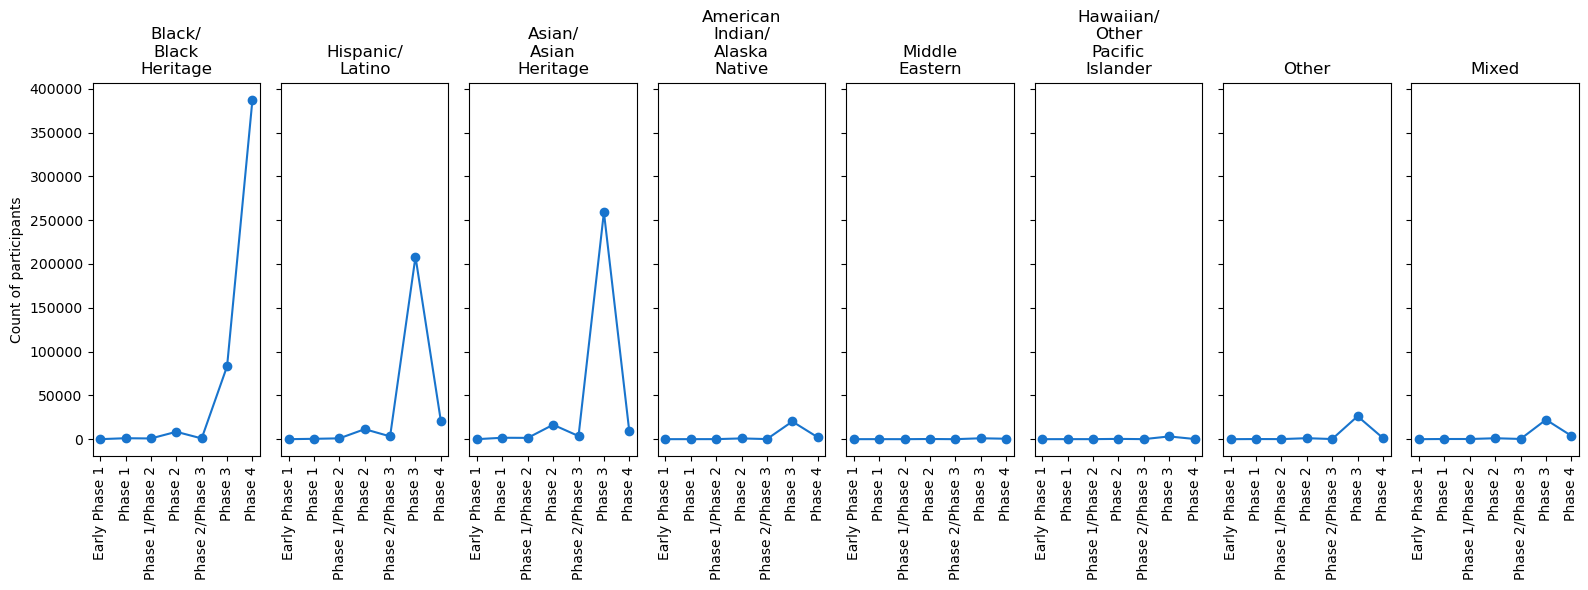

In [241]:
# Extract relevant columns for race/ethnicity and phase
race_ethnicity = ['Black/ Black Heritage', 'Hispanic/ Latino', 'Asian/ Asian Heritage', 'American Indian/ Alaska Native', 'Middle Eastern', 'Hawaiian/ Other Pacific Islander', 'Other', 'Mixed']
phases = ['Early Phase 1', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4']
df_plot = df_race_phase_viz[race_ethnicity + ['phase']]

# Set up the plot
fig, axs = plt.subplots(1, len(race_ethnicity), figsize=(16, 6), sharey=True)

# Plot each race next to each other
for i, race in enumerate(race_ethnicity):
    ax = axs[i]
    values = df_plot.loc[df_plot['phase'].isin(phases)][race].tolist()
    ax.plot(range(len(values)), values, marker='o', linestyle='-', color='#1874CD', label=race)

    # Set x-axis labels
    ax.set_xticks(range(len(phases)))
    ax.set_xticklabels(phases, rotation=90)

    # Set y-axis label (only for the first subplot)
    if i == 0:
        ax.set_ylabel('Count of participants')

    # Wrap the race name and set title
    wrapped_race = '\n'.join(textwrap.wrap(race, width=10))
    ax.set_title(wrapped_race)

# Adjust spacing between subplots
plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/participants_phase_notWhite.png', dpi=300)

# Show the plots
plt.show()


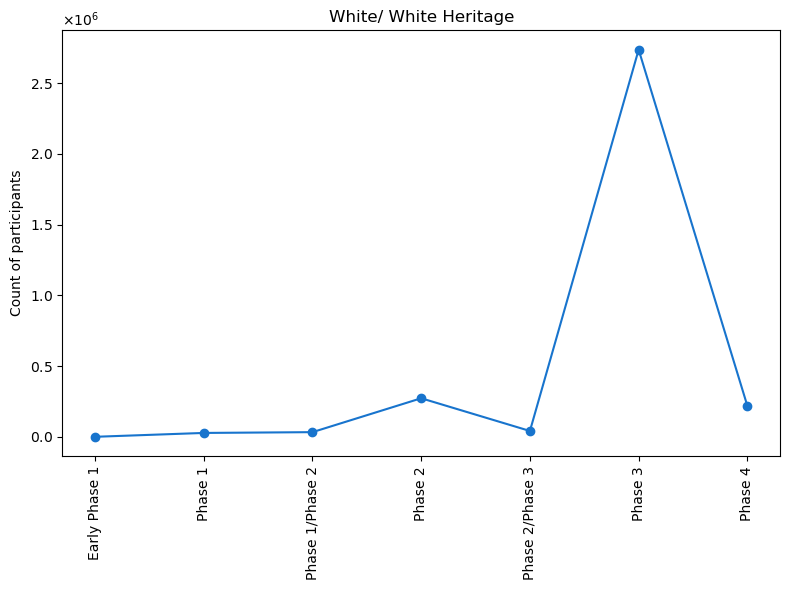

In [242]:
# Extract relevant columns for race/ethnicity and phase
race_ethnicity = ['White/ White Heritage']
phases = ['Early Phase 1', 'Phase 1', 'Phase 1/Phase 2', 'Phase 2', 'Phase 2/Phase 3', 'Phase 3', 'Phase 4']
df_plot = df_race_phase_viz[race_ethnicity + ['phase']]

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the race
values = df_plot.loc[df_plot['phase'].isin(phases)][race_ethnicity[0]].tolist()
ax.plot(range(len(values)), values, marker='o', linestyle='-', color='#1874CD', label=race_ethnicity[0])

# Set x-axis labels
ax.set_xticks(range(len(phases)))
ax.set_xticklabels(phases, rotation=90)

# Set y-axis label
ax.set_ylabel('Count of participants')

# Set title and legend
ax.set_title(race_ethnicity[0])

# Format y-axis tick labels as whole numbers
plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter(useOffset=False, useMathText=True))

# Adjust padding around the figure
plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/participants_phase_WHITE.png', dpi=300)

# Show the plot
plt.show()

In [243]:
# Calculate the sum for each row
df_race_phase_viz['Phase total'] = df_race_phase_viz.sum(axis=1)

/tmp/ipykernel_139/3369688594.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [244]:
df_race_phase_viz

phase  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0    Early Phase 1                             0.0                   12.0   
2          Phase 1                            30.0                 1619.0   
3  Phase 1/Phase 2                            54.0                 1468.0   
4          Phase 2                           858.0                16468.0   
5  Phase 2/Phase 3                           116.0                 3569.0   
6          Phase 3                         20179.0               259038.0   
7          Phase 4                          2176.0                 8852.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                   19.0                               0.0              11.0   
2                 1079.0                              41.0             401.0   
3                  805.0                              32.0             926.0   
4                 8430.0                             319.0           11414.0   
5                  850.0                              38.0            3192.0   
6                83175.0                            3120.0          208270.0   
7               387688.0                             193.0           20489.0   

   Middle Eastern    Mixed    Other  Unknown or Not Reported  \
0             0.0      6.0      0.0                     17.0   
2            30.0    193.0    147.0                   1342.0   
3             0.0    188.0     80.0                   3425.0   
4           196.0   1054.0   1120.0                  15227.0   
5             0.0    257.0    157.0                   2857.0   
6          1014.0  22218.0  26158.0                 203117.0   
7           502.0   3831.0   1305.0                  19718.0   

   White/ White Heritage  Phase total  
0                  545.0        610.0  
2                27830.0      32712.0  
3                33389.0      40367.0  
4               273016.0     328102.0  
5                41733.0      52769.0  
6              2737309.0    3563598.0  
7               218821.0     663575.0

In [245]:
# Calculate the percentage for each race in each phase
races = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

for race in races:
    df_race_phase_viz[race + ' (%)'] = round((df_race_phase_viz[race] / df_race_phase_viz['Phase total']) * 100,2)
    
df_race_phase_viz

phase  American Indian/ Alaska Native  Asian/ Asian Heritage  \
0    Early Phase 1                             0.0                   12.0   
2          Phase 1                            30.0                 1619.0   
3  Phase 1/Phase 2                            54.0                 1468.0   
4          Phase 2                           858.0                16468.0   
5  Phase 2/Phase 3                           116.0                 3569.0   
6          Phase 3                         20179.0               259038.0   
7          Phase 4                          2176.0                 8852.0   

   Black/ Black Heritage  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  \
0                   19.0                               0.0              11.0   
2                 1079.0                              41.0             401.0   
3                  805.0                              32.0             926.0   
4                 8430.0                             319.0           11414.0   
5                  850.0                              38.0            3192.0   
6                83175.0                            3120.0          208270.0   
7               387688.0                             193.0           20489.0   

   Middle Eastern    Mixed    Other  Unknown or Not Reported  ...  \
0             0.0      6.0      0.0                     17.0  ...   
2            30.0    193.0    147.0                   1342.0  ...   
3             0.0    188.0     80.0                   3425.0  ...   
4           196.0   1054.0   1120.0                  15227.0  ...   
5             0.0    257.0    157.0                   2857.0  ...   
6          1014.0  22218.0  26158.0                 203117.0  ...   
7           502.0   3831.0   1305.0                  19718.0  ...   

   Phase total  White/ White Heritage (%)  Black/ Black Heritage (%)  \
0        610.0                      89.34                       3.11   
2      32712.0                      85.08                       3.30   
3      40367.0                      82.71                       1.99   
4     328102.0                      83.21                       2.57   
5      52769.0                      79.09                       1.61   
6    3563598.0                      76.81                       2.33   
7     663575.0                      32.98                      58.42   

   Hispanic/ Latino (%)  Asian/ Asian Heritage (%)  \
0                  1.80                       1.97   
2                  1.23                       4.95   
3                  2.29                       3.64   
4                  3.48                       5.02   
5                  6.05                       6.76   
6                  5.84                       7.27   
7                  3.09                       1.33   

   American Indian/ Alaska Native (%)  Middle Eastern (%)  \
0                                0.00                0.00   
2                                0.09                0.09   
3                                0.13                0.00   
4                                0.26                0.06   
5                                0.22                0.00   
6                                0.57                0.03   
7                                0.33                0.08   

   Hawaiian/ Other Pacific Islander (%)  Other (%)  Mixed (%)  
0                                  0.00       0.00       0.98  
2                                  0.13       0.45       0.59  
3                                  0.08       0.20       0.47  
4                                  0.10       0.34       0.32  
5                                  0.07       0.30       0.49  
6                                  0.09       0.73       0.62  
7                                  0.03       0.20       0.58  

[7 rows x 21 columns]

In [246]:
df_race_phase_perc = df_race_phase_viz.iloc[:,[0,12,13,14,15,16,17,18,19,20]]

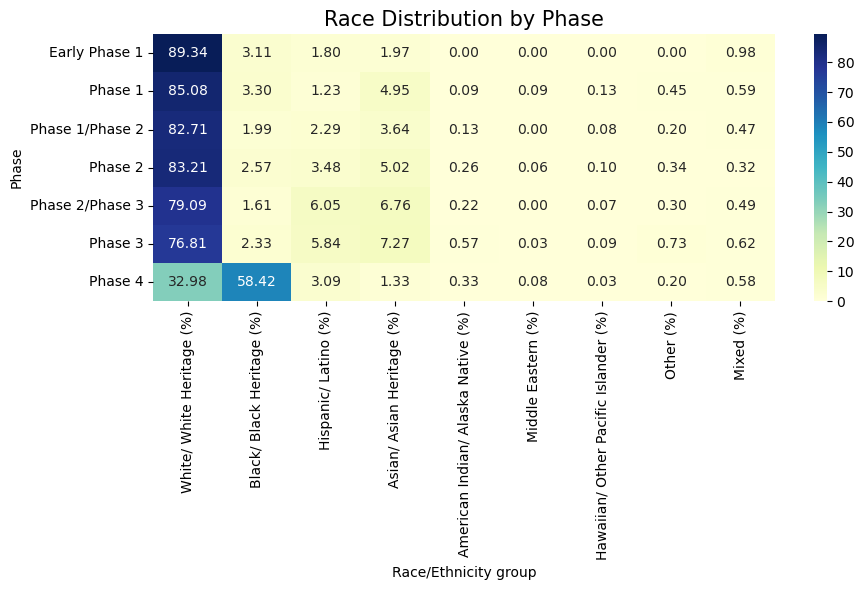

In [247]:
# Set the "Phase" column as the index
df_race_phase_perc.set_index('phase', inplace=True)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_race_phase_perc, annot=True, fmt=".2f", cmap='YlGnBu')

# Customize the plot
plt.title('Race Distribution by Phase', fontsize=15)
plt.xlabel('Race/Ethnicity group')
plt.ylabel('Phase')

# Adjust the figure layout to ensure all content is visible
plt.tight_layout(rect=[0, 0, 0.95, 1]) 

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/heatmap_race_phase.png', dpi=300)

# Display the heatmap
plt.show()

# Cancer

In [248]:
uk_filtered.head()

nct_id  start_date                                        brief_title  \
0  NCT03899792  2019-06-13  A Study of Oral LOXO-292 (Selpercatinib) in Pe...   
1  NCT03850782  2019-02-28  Evaluation of the Duration of Effect of Bimato...   
2  NCT03783442  2018-12-11  A Study of Tislelizumab (BGB-A317) in Combinat...   
3  NCT03693300  2019-04-16  A Study to Determine Safety of Durvalumab Afte...   
4  NCT01539187  2012-06-30            Fibroid Ablation Study - Large Fibroids   

                                      official_title          overall_status  \
0  A Phase 1/2 Study of the Oral RET Inhibitor LO...              Recruiting   
1  A Phase 3b Study to Evaluate the Duration of E...  Active, not recruiting   
2  A Randomized, Placebo-Controlled, Double-Blind...  Active, not recruiting   
3  A Phase II, Open-Label, Multi-Centre, Internat...               Completed   
4  Symptom Effectiveness Study of VizAblate® Intr...              Terminated   

             phase  enrollment enrollment_type  number_of_arms  results  
0  Phase 1/Phase 2       100.0     Anticipated             1.0        0  
1          Phase 3       515.0          Actual             2.0        0  
2          Phase 3       649.0          Actual             2.0        0  
3          Phase 2       117.0          Actual             2.0        1  
4   Not Applicable         6.0          Actual             1.0        0

In [250]:
# Create a list of cancer-related terms
cancer_terms = ['cancer', 'tumor', 'tumour', 'carcinoma', 'lymphoma', 'leukemia', 'sarcoma', 'glioblastoma',
                'glioma', 'neuroblastoma', 'papilloma', 'melanoma', 'metastasis', 'malignant', 'benign',
                'leukemia', 'histiocytoma', 'adenocarcinoma', 'aldosteronoma', 'adamantinoma', 'ameloblastoma',
                'angiofibroma', 'angiosarcoma', 'astroblastoma', 'astrocytoma', 'liponeurocytoma', 'cholangiocarcinoma',
                'chondroblastoma', 'chondrosarcoma', 'chordoma', 'nephroma', 'craniopharyngioma', 'cystadenoma',
                'nephroblastoma', 'chondrosarcoma', 'trichoepithelioma', 'ependymoma', 'hemangioendothelioma',
                'erythroleukemia', 'fibroadenoma', 'fibrosarcoma', 'germinoma', 'glioblastoma', 'osteosarcoma',
                'rhabdomyosarcoma', 'leiomyosarcoma', 'myxosarcoma', 'mesenchymoma', 'astrocytoma', 'ependymoma',
                'neuroblastoma', 'oligodendroglioma', 'pheochromocytoma', 'retinoblastoma', 'cholangiocarcinoma',
                'myelodysplastic', 'liposarcoma', 'histiocytoma', 'macroglobulinaemia', 'polycythaemia vera',
                'essential thrombocythaemia', 'myelofibrosis', 'gastrinoma', 'hemangioendothelioma', 'hepatoblastoma',
                'insulinoma', 'keratoacanthoma', 'leiomyosarcoma', 'liposarcoma', 'mesenchymoma', 'medulloepithelioma',
                'meningioma', 'nephroma', 'myxofibrosarcoma', 'nephroblastoma', 'esthesioneuroblastoma', 'pheochromocytoma',
                'pineoblastoma', 'plasmacytoma', 'prolactinoma', 'fibrosarcoma', 'somatostatinoma', 'haemangioblastoma',
                'thymoma', 'seminoma', 'dysgerminoma', 'oncocytic', 'paraganglioma', 'teratoma', 'mesothelioma',
                'neoplasia', 'phaeochromocytoma', 'acoustic neuroma', 'neuroma', 'nephroblastoma', 'mycosis fungoides',
                'vipoma', 'oncocytic', 'oncocytomas', 'teratoma', 'gestational trophoblastic disease', 'hodgkin',
                'burkitt', 'wilms', 'kaposi', 'paget', 'edwig', 'schwannoma', 'verner-morrison', 'waldenström',
                'von recklinghausen', 'von hippel-lindau', 'peutz-jeghers', 'neurofibromatosis type 2', 'carney', 'gorlin']

# Create a regex pattern by joining the cancer terms and making them case-insensitive
pattern = re.compile(r'|'.join(cancer_terms), re.IGNORECASE)

# Filter for cancer-related trials
cancer_df = uk_filtered[
    (uk_filtered['official_title'].str.contains(pattern, na=False)) |
    (uk_filtered['brief_title'].str.contains(pattern, na=False))
]

cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3919 entries, 0 to 18849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nct_id           3919 non-null   object 
 1   start_date       3919 non-null   object 
 2   brief_title      3919 non-null   object 
 3   official_title   3912 non-null   object 
 4   overall_status   3919 non-null   object 
 5   phase            3919 non-null   object 
 6   enrollment       3904 non-null   float64
 7   enrollment_type  3861 non-null   object 
 8   number_of_arms   3612 non-null   float64
 9   results          3919 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 336.8+ KB


There are **3919** UK Clinical Interventional trials from 2002-2022 that were focused on cancer related deseases (e.g., cacner, lymphoma, glioblastoma, metastasis, malignant, benign, leukemia).

In [251]:
cancer_df['results'].value_counts(normalize=True)

0    0.659862
1    0.340138
Name: results, dtype: float64

**34.0%** of those trials released results.

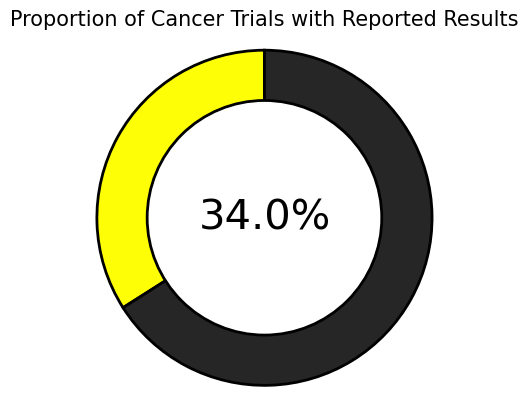

In [252]:
# Calculate the counts
cancer_count_results = cancer_df['results'].sum()
cancer_count_no_results = len(cancer_df) - cancer_count_results

# Calculate the proportions
cancer_total_trials = len(cancer_df)
cancer_proportion_results = cancer_count_results / cancer_total_trials
cancer_proportion_no_results = cancer_count_no_results / cancer_total_trials

# Create the donut chart
labels = ['Results Reported', 'Results Not Reported']
sizes = [cancer_proportion_results, cancer_proportion_no_results]
colors = ['#fefe06', '#262626']
outline_color = '#000000'  # Outline color

plt.pie(sizes, labels=None, colors=colors, startangle=90, wedgeprops={'edgecolor': outline_color, 'linewidth': 2})
plt.title('Proportion of Cancer Trials with Reported Results', fontsize=15)

# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white', ec=outline_color, lw=2)  # Add outline to the center circle
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the value of "Results Reported" in the middle of the donut chart
plt.text(0, 0, f'{cancer_proportion_results*100:.1f}%', horizontalalignment='center', verticalalignment='center', fontsize=30, color='black')

# Set aspect ratio to be equal so that the pie is drawn as a circle
plt.axis('equal')

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/cancer_donut_chart.png', dpi=300)

# Display the chart
plt.show()

In [253]:
cancer_df_res = cancer_df[cancer_df['results']==1]

In [254]:
print('There are ' + str(cancer_df_res.nct_id.nunique()) + ' trials that released results and are focused around cancer research.')

There are 1333 trials that released results and are focused around cancer research.


In [255]:
cancer_race = pd.merge(cancer_df_res, df_race_trials, on='nct_id',how='inner')

cancer_race.head()

nct_id start_date_x  \
0  NCT03693300   2019-04-16   
1  NCT02667587   2016-05-09   
2  NCT02246621   2014-11-06   
3  NCT01772472   2013-04-03   
4  NCT02367456   2015-04-28   

                                         brief_title  \
0  A Study to Determine Safety of Durvalumab Afte...   
1  An Investigational Immuno-therapy Study of Tem...   
2  A Study of Nonsteroidal Aromatase Inhibitors P...   
3  A Study of Trastuzumab Emtansine Versus Trastu...   
4  A Combination Study of PF-04449913 (Glasdegib)...   

                                      official_title          overall_status  \
0  A Phase II, Open-Label, Multi-Centre, Internat...               Completed   
1  A Randomized Phase 3 Single Blind Study of Tem...  Active, not recruiting   
2  A Randomized, Double-Blind, Placebo-Controlled...  Active, not recruiting   
3  A Randomized, Multicenter, Open-Label Phase II...  Active, not recruiting   
4  An Open-label Phase 1b Study of PF-04449913 (G...               Completed   

     phase  enrollment enrollment_type  number_of_arms  results  ...  \
0  Phase 2       117.0          Actual             2.0        1  ...   
1  Phase 3       716.0          Actual             2.0        1  ...   
2  Phase 3       493.0          Actual             2.0        1  ...   
3  Phase 3      1487.0          Actual             2.0        1  ...   
4  Phase 1        73.0          Actual             2.0        1  ...   

  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                              0.0               2.0             0.0    0.0   
1                              0.0              36.0             0.0    0.0   
2                              2.0              88.0             0.0    4.0   
3                              2.0               0.0             0.0    4.0   
4                              0.0               6.0             0.0    0.0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  count  \
0    0.0                     46.0                  420.0             0      1   
1   40.0                    700.0                 1936.0             0      1   
2    0.0                    266.0                 1286.0             0      1   
3    0.0                    292.0                 2164.0             0      1   
4    2.0                     44.0                  230.0             0      1   

   year  
0  2019  
1  2016  
2  2014  
3  2013  
4  2015  

[5 rows x 24 columns]

In [256]:
print('There are ' + str(cancer_race.nct_id.nunique()) + ' trials that released results on race and are focused around cancer research.')

There are 627 trials that released results on race and are focused around cancer research.


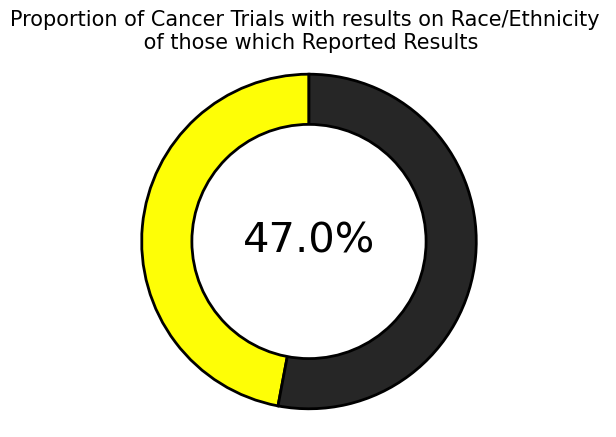

In [257]:
# Calculate the counts
cancer_count_results = cancer_race.nct_id.nunique()
cancer_count_no_results = cancer_df_res.nct_id.nunique() - cancer_count_results

# Calculate the proportions
cancer_total_trials = cancer_df_res.nct_id.nunique()
cancer_proportion_results = cancer_count_results / cancer_total_trials
cancer_proportion_no_results = cancer_count_no_results / cancer_total_trials

# Create the donut chart
labels = ['Results Reported', 'Results Not Reported']
sizes = [cancer_proportion_results, cancer_proportion_no_results]
colors = ['#fefe06', '#262626']
outline_color = '#000000'  # Outline color

plt.pie(sizes, labels=None, colors=colors, startangle=90, wedgeprops={'edgecolor': outline_color, 'linewidth': 2})
plt.title('Proportion of Cancer Trials with results on Race/Ethnicity \n of those which Reported Results', fontsize=15)

# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white', ec=outline_color, lw=2)  # Add outline to the center circle
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the value of "Results Reported" in the middle of the donut chart
plt.text(0, 0, f'{cancer_proportion_results*100:.1f}%', horizontalalignment='center', verticalalignment='center', fontsize=30, color='black')

# Set aspect ratio to be equal so that the pie is drawn as a circle
plt.axis('equal')

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/cancer_race_results_donut_chart.png', dpi=300)

# Display the chart
plt.show()

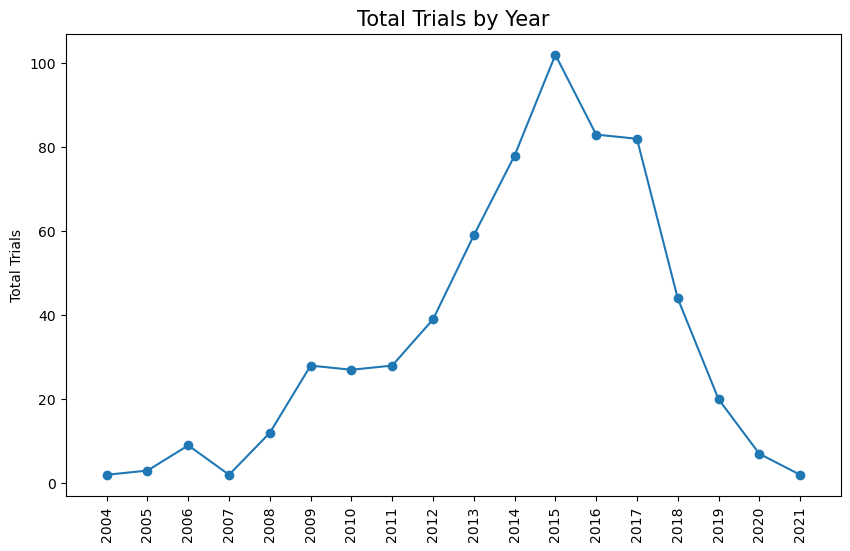

In [258]:
# Group the trials by year and calculate the total count
trial_count_by_year = cancer_race.groupby('year')['count'].sum()

# Plot the total trials by year
plt.figure(figsize=(10, 6))
trial_count_by_year.plot(marker='o')
plt.ylabel('Total Trials')
plt.xlabel('')
plt.title('Total Trials by Year', fontsize=15)
plt.xticks(range(min(cancer_race['year']), max(cancer_race['year'])+1), rotation=90)
plt.xlim(min(cancer_race['year'])-1, max(cancer_race['year'])+1)
plt.grid(False)

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/Cancer_trials_years.png', dpi=300)

plt.show()

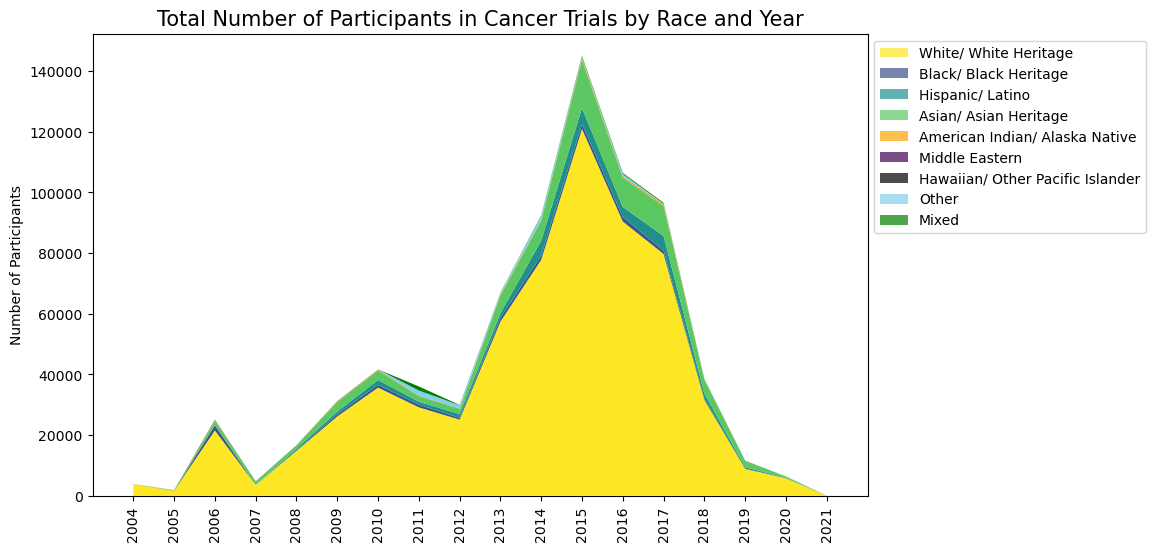

In [259]:
# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

# Extract unique race/ethnicity values
# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

race_ethnicities = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

# Group the trials by year and race, and calculate the total count for each race by year
race_count_by_year = cancer_race.groupby(['year'])[race_ethnicities].sum()

# Create the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(race_count_by_year.index, race_count_by_year.values.T, labels=race_ethnicities, colors=colors[:len(race_ethnicities)])

# Add the custom legend
patch_handles = [mpatches.Patch(facecolor=colors[i], alpha=0.7) for i in range(len(race_ethnicities))]
legend_labels = race_ethnicities
plt.legend(patch_handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.ylabel('Number of Participants')
plt.title('Total Number of Participants in Cancer Trials by Race and Year', fontsize=15)
plt.xticks(range(min(cancer_race['year']), max(cancer_race['year'])+1), rotation=90)
plt.xlim(min(cancer_race['year'])-1, max(cancer_race['year'])+1)
plt.grid(False)

# Save the chart as an image file using the savefig() function
plt.savefig('/project/charts_uk_and_other/Cancer_trials_stacked_area_years.png', dpi=300)

plt.show()


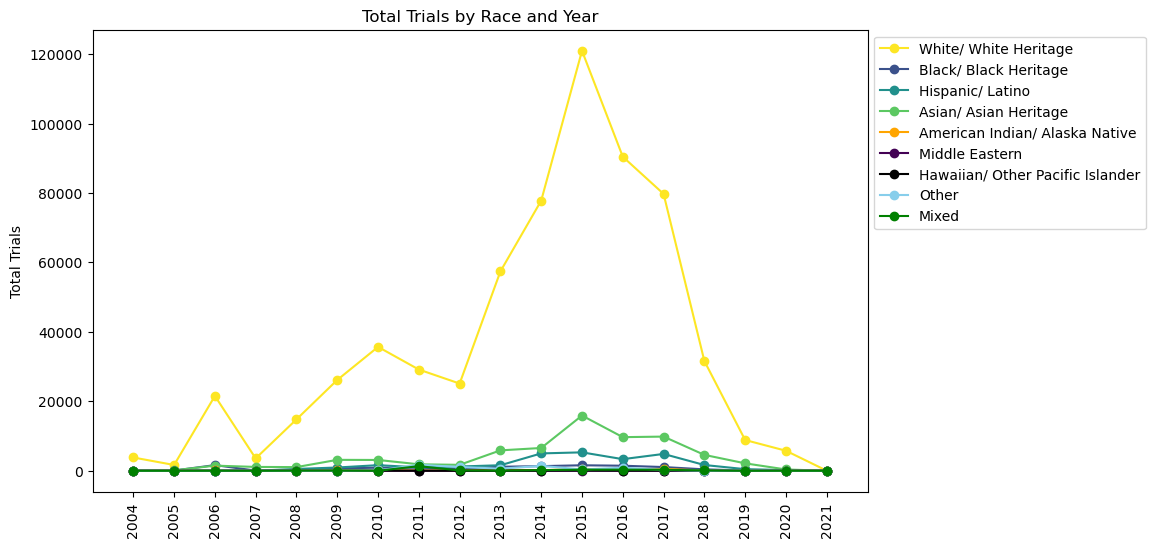

In [260]:
# Define the colors for each race/ethnicity
# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

race_ethnicities = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

# Group the trials by year and race, and calculate the total count for each race by year
race_count_by_year = cancer_race.groupby(['year'])[race_ethnicities].sum()

# Plot the lines for each race
plt.figure(figsize=(10, 6))
for i, race in enumerate(race_count_by_year.columns):
    plt.plot(race_count_by_year.index, race_count_by_year[race], marker='o', color=colors[i], label=race)

plt.ylabel('Total Trials')
plt.title('Total Trials by Race and Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(range(min(cancer_race['year']), max(cancer_race['year'])+1), rotation=90)
plt.xlim(min(cancer_race['year'])-1, max(cancer_race['year'])+1)
plt.grid(False)

# Save the chart as an image file using the savefig() function
plt.savefig('/project/charts_uk_and_other/Cancer_trials_years.png', dpi=300)

plt.show()

In [261]:
# Define the colors for each race/ethnicity
# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']

race_ethnicities = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

# Group the trials by year and race, and calculate the total count for each race by year
race_count_by_year = cancer_race.groupby(['year'])[race_ethnicities].sum()

# Create an empty list to store the line traces
data = []

# Create a line trace for each race
for i, race in enumerate(race_count_by_year.columns):
    trace = go.Scatter(
        x=race_count_by_year.index,
        y=race_count_by_year[race],
        mode='lines+markers',
        name=race,
        marker=dict(
            color=colors[i]
        )
    )
    data.append(trace)

# Create the layout
layout = go.Layout(
    title='Total Trials by Race and Year',
    xaxis=dict(
        title='Year',
        tickmode='linear',
        tick0=min(cancer_race['year']),
        dtick=1,
        tickangle=90
    ),
    yaxis=dict(
        title='Total Trials'
    ),
    legend=dict(
        x=1,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)'
    )
)

# Create the figure and plot the chart
fig = go.Figure(data=data, layout=layout)
fig.show()


<Figure size 1000x600 with 0 Axes>

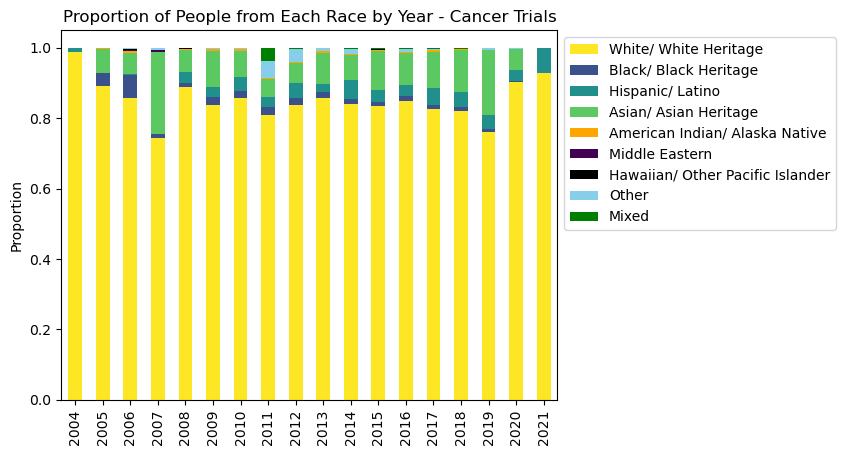

In [262]:
# Group the trials by year and race, and calculate the total count for each race by year
race_count_by_year = cancer_race.groupby('year')[['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']].sum()

# Calculate the proportion for each race by year
race_proportion_by_year = race_count_by_year.div(race_count_by_year.sum(axis=1), axis=0)

# Define the colors for each race/ethnicity
# Plot the proportion of trials reporting each race/ethnicity over time
colors = ['#fde624', '#3b518b', '#21908c', '#5cc862', 'orange', '#430154','black','skyblue','green']


# Plot the composite bar chart
plt.figure(figsize=(10, 6))
race_proportion_by_year.plot(kind='bar', stacked=True, color=colors)
plt.ylabel('Proportion')
plt.xlabel('')
plt.title('Proportion of People from Each Race by Year - Cancer Trials')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(False)

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/stacked_bar_CANCER_100.png', dpi=300)

plt.show()

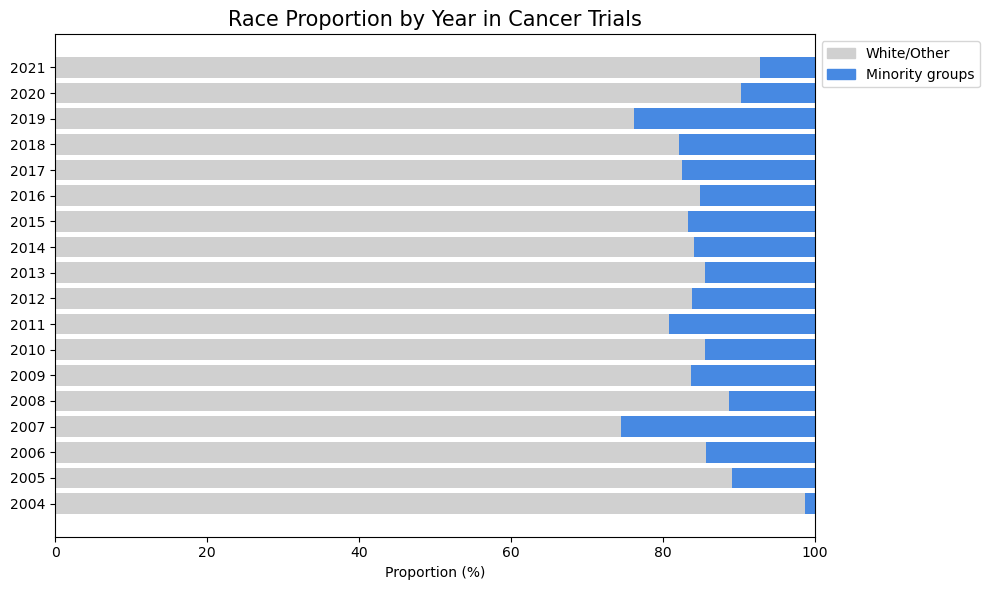

In [263]:
# Define the race categories and colors
race_categories = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']
race_colors = ['#d0d0d0', '#4789e2', '#4789e2', '#4789e2','#4789e2', '#4789e2', '#4789e2','#4789e2', '#4789e2']

# Set the years and their index positions
years = race_proportion_by_year.index
years_idx = range(len(years))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the horizontal stacked bars
bars = []
for i, race in enumerate(race_categories):
    proportion = race_proportion_by_year.loc[:, race] * 100
    bottom = race_proportion_by_year.loc[:, race_categories[:i]].sum(axis=1) * 100
    bars.append(ax.barh(years_idx, proportion, color=race_colors[i], left=bottom))

# Set the y-axis ticks and labels
ax.set_yticks(years_idx)
ax.set_yticklabels(years)

# Set the x-axis label
ax.set_xlabel('Proportion (%)')

# Set the chart title
ax.set_title('Race Proportion by Year in Cancer Trials', fontsize=15)

# Create a custom legend
legend_labels = ['White/Other','Minority groups']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=race_colors[0]), plt.Rectangle((0, 0), 1, 1, color=race_colors[-1])]
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1, 1))

# Adjust the layout
plt.tight_layout()

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/horizontal_stacked_bar_chart.png', dpi=300)

# Show the plot
plt.show()

In [264]:
cancer_race_dummies = cancer_race.copy()

# Create dummy variables for race columns
race_columns = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed']

# Convert zeros to null for race columns
cancer_race_dummies[race_columns] = cancer_race_dummies[race_columns].replace(0, np.nan)

# Convert null values to 0 and non-null values to 1 for race columns
cancer_race_dummies[race_columns] = cancer_race_dummies[race_columns].notnull().astype(int).fillna(0)

cancer_race_dummies.head()

nct_id start_date_x  \
0  NCT03693300   2019-04-16   
1  NCT02667587   2016-05-09   
2  NCT02246621   2014-11-06   
3  NCT01772472   2013-04-03   
4  NCT02367456   2015-04-28   

                                         brief_title  \
0  A Study to Determine Safety of Durvalumab Afte...   
1  An Investigational Immuno-therapy Study of Tem...   
2  A Study of Nonsteroidal Aromatase Inhibitors P...   
3  A Study of Trastuzumab Emtansine Versus Trastu...   
4  A Combination Study of PF-04449913 (Glasdegib)...   

                                      official_title          overall_status  \
0  A Phase II, Open-Label, Multi-Centre, Internat...               Completed   
1  A Randomized Phase 3 Single Blind Study of Tem...  Active, not recruiting   
2  A Randomized, Double-Blind, Placebo-Controlled...  Active, not recruiting   
3  A Randomized, Multicenter, Open-Label Phase II...  Active, not recruiting   
4  An Open-label Phase 1b Study of PF-04449913 (G...               Completed   

     phase  enrollment enrollment_type  number_of_arms  results  ...  \
0  Phase 2       117.0          Actual             2.0        1  ...   
1  Phase 3       716.0          Actual             2.0        1  ...   
2  Phase 3       493.0          Actual             2.0        1  ...   
3  Phase 3      1487.0          Actual             2.0        1  ...   
4  Phase 1        73.0          Actual             2.0        1  ...   

  Hawaiian/ Other Pacific Islander  Hispanic/ Latino  Middle Eastern  Mixed  \
0                                0                 1               0      0   
1                                0                 1               0      0   
2                                1                 1               0      1   
3                                1                 0               0      1   
4                                0                 1               0      0   

   Other  Unknown or Not Reported  White/ White Heritage  uk_races_dum  count  \
0      0                     46.0                      1             0      1   
1      1                    700.0                      1             0      1   
2      0                    266.0                      1             0      1   
3      0                    292.0                      1             0      1   
4      1                     44.0                      1             0      1   

   year  
0  2019  
1  2016  
2  2014  
3  2013  
4  2015  

[5 rows x 24 columns]

In [265]:
cancer_race_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627 entries, 0 to 626
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   nct_id                            627 non-null    object        
 1   start_date_x                      627 non-null    object        
 2   brief_title                       627 non-null    object        
 3   official_title                    627 non-null    object        
 4   overall_status                    627 non-null    object        
 5   phase                             627 non-null    object        
 6   enrollment                        627 non-null    float64       
 7   enrollment_type                   627 non-null    object        
 8   number_of_arms                    626 non-null    float64       
 9   results                           627 non-null    int64         
 10  start_date_y                      627 non-null    

In [266]:
cancer_race_table = cancer_race_dummies.iloc[:,[9,11,12,13,14,15,16,17,18,19,20,21,22,23]]

In [267]:
# Reshape the dataframe using melt
melted_df = cancer_race_table.melt(id_vars='count', var_name='Race', value_name='Count')

# Calculate the sum for each race
cancer_race_table = melted_df.groupby('Race')['Count'].sum()

In [268]:
# Create the dataframe
cancer_race_table = pd.DataFrame(cancer_race_table)

In [269]:
cancer_race_table.reset_index(inplace=True)
cancer_race_table

Race      Count
0     American Indian/ Alaska Native      192.0
1              Asian/ Asian Heritage      472.0
2              Black/ Black Heritage      456.0
3   Hawaiian/ Other Pacific Islander      124.0
4                   Hispanic/ Latino      395.0
5                     Middle Eastern       13.0
6                              Mixed      120.0
7                              Other      114.0
8            Unknown or Not Reported    59294.0
9              White/ White Heritage      626.0
10                           results      627.0
11                      uk_races_dum        7.0
12                              year  1262950.0

In [270]:
cancer_race_table['Proportion of trials (%)'] = round((cancer_race_table['Count'] / 627)*100,2)

In [271]:
cancer_race_table

Race      Count  Proportion of trials (%)
0     American Indian/ Alaska Native      192.0                     30.62
1              Asian/ Asian Heritage      472.0                     75.28
2              Black/ Black Heritage      456.0                     72.73
3   Hawaiian/ Other Pacific Islander      124.0                     19.78
4                   Hispanic/ Latino      395.0                     63.00
5                     Middle Eastern       13.0                      2.07
6                              Mixed      120.0                     19.14
7                              Other      114.0                     18.18
8            Unknown or Not Reported    59294.0                   9456.78
9              White/ White Heritage      626.0                     99.84
10                           results      627.0                    100.00
11                      uk_races_dum        7.0                      1.12
12                              year  1262950.0                 201427.43

In [272]:
# Define the race order for plotting
race_order = ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed','uk_races_dum']

# Sort the dataframe based on the race_order
cancer_race_table_sorted = cancer_race_table[cancer_race_table['Race'].isin(race_order)].sort_values('Race', key=lambda x: x.map({k: i for i, k in enumerate(race_order)}))

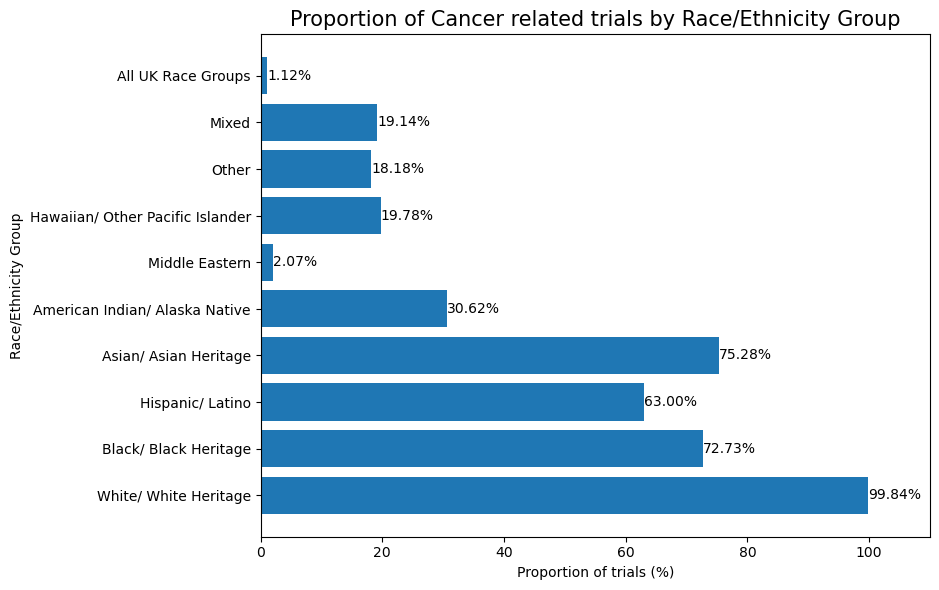

In [273]:
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(cancer_race_table_sorted['Race'], cancer_race_table_sorted['Proportion of trials (%)'])

# Customize the plot
plt.title('Proportion of Cancer related trials by Race/Ethnicity Group', fontsize=15)
plt.ylabel('Race/Ethnicity Group')
plt.xlabel('Proportion of trials (%)')
plt.xticks(rotation=0)
plt.xlim(0, 110)

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', ha='left', va='center')

# Change the label for 'uk_races_dum'
plt.yticks(range(len(cancer_race_table_sorted)), ['White/ White Heritage' ,'Black/ Black Heritage','Hispanic/ Latino','Asian/ Asian Heritage' ,'American Indian/ Alaska Native', 'Middle Eastern' ,'Hawaiian/ Other Pacific Islander','Other' ,'Mixed', 'All UK Race Groups'])

# Adjust the figure layout to ensure all content is visible
plt.tight_layout(rect=[0, 0, 0.95, 1])  

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/cancer_proportion_horizontal_barchart.png', dpi=300)

# Display the plot
plt.show()

In [274]:
# Create a copy of the cancer_race DataFrame
cancer_race_dummy = cancer_race.copy()

# Create dummy variables for cancer-related terms in the title and description columns
for term in cancer_terms:
    cancer_race_dummy[f'dummy_{term}'] = cancer_race_dummy['brief_title'].str.contains(term, case=False) | cancer_race_dummy['official_title'].str.contains(term, case=False)
    cancer_race_dummy[f'dummy_{term}'] = cancer_race_dummy[f'dummy_{term}'].astype(int)

/tmp/ipykernel_139/997304004.py:6: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [275]:
# Create an empty dataframe
cancer_terms_df = pd.DataFrame()

# Extract the columns corresponding to the cancer_terms
for term in cancer_terms:
    column_name = f'dummy_{term}'
    cancer_terms_df[column_name] = cancer_race_dummy[column_name]

# Display the resulting datafram
cancer_terms_df

dummy_cancer  dummy_tumor  dummy_tumour  dummy_carcinoma  dummy_lymphoma  \
0               1            0             0                0               0   
1               1            1             0                0               0   
2               1            0             0                0               0   
3               1            1             0                0               0   
4               0            0             0                0               0   
..            ...          ...           ...              ...             ...   
622             0            0             0                0               0   
623             0            0             0                1               0   
624             0            1             0                0               0   
625             0            0             0                0               0   
626             1            0             0                0               0   

     dummy_leukemia  dummy_sarcoma  dummy_glioblastoma  dummy_glioma  \
0                 0              0                   0             0   
1                 0              0                   1             0   
2                 0              0                   0             0   
3                 0              0                   0             0   
4                 1              0                   0             0   
..              ...            ...                 ...           ...   
622               0              0                   0             0   
623               0              0                   0             0   
624               0              0                   0             0   
625               0              0                   0             0   
626               0              0                   0             0   

     dummy_neuroblastoma  ...  dummy_edwig  dummy_schwannoma  \
0                      0  ...            0                 0   
1                      0  ...            0                 0   
2                      0  ...            0                 0   
3                      0  ...            0                 0   
4                      0  ...            0                 0   
..                   ...  ...          ...               ...   
622                    0  ...            0                 0   
623                    0  ...            0                 0   
624                    0  ...            0                 0   
625                    0  ...            0                 0   
626                    0  ...            0                 0   

     dummy_verner-morrison  dummy_waldenström  dummy_von recklinghausen  \
0                        0                  0                         0   
1                        0                  0                         0   
2                        0                  0                         0   
3                        0                  0                         0   
4                        0                  0                         0   
..                     ...                ...                       ...   
622                      0                  0                         0   
623                      0                  0                         0   
624                      0                  0                         0   
625                      0                  0                         0   
626                      0                  0                         0   

     dummy_von hippel-lindau  dummy_peutz-jeghers  \
0                          0                    0   
1                          0                    0   
2                          0                    0   
3                          0                    0   
4                          0                    0   
..                       ...                  ...   
622                        0                    0   
623                        0                    0   
624                 

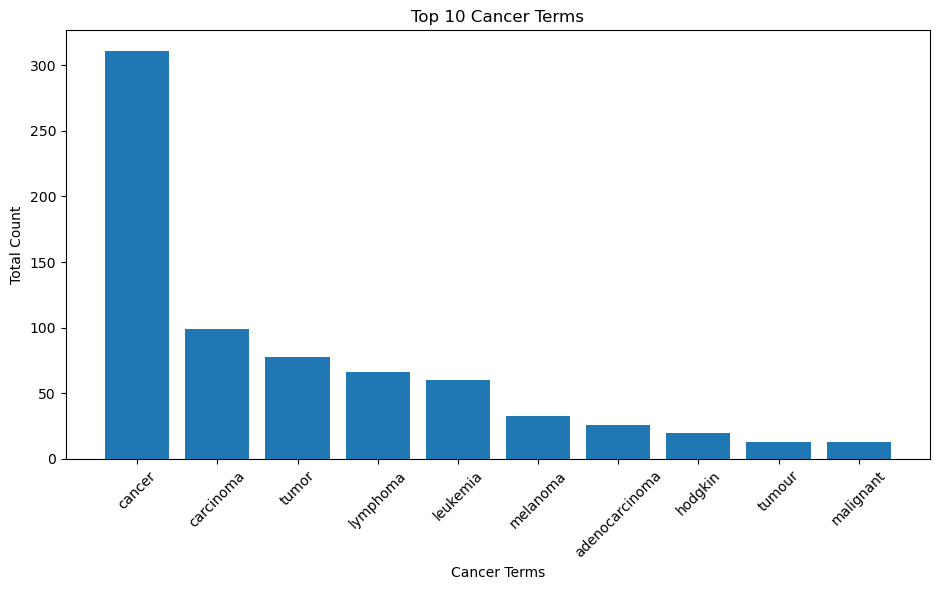

In [276]:
# Calculate the total count for each column
column_totals = cancer_terms_df.sum()

# Sort the columns by total count in descending order
sorted_columns = column_totals.sort_values(ascending=False)

# Select the top 10 columns
top_10_columns = sorted_columns[:10]

# Remove the "dummy_" part from the column names
column_labels = [col.replace('dummy_', '') for col in top_10_columns.index]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(column_labels, top_10_columns.values)

# Customize the plot
plt.title('Top 10 Cancer Terms')
plt.xlabel('Cancer Terms')
plt.ylabel('Total Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust the figure layout to ensure all content is visible
plt.tight_layout(rect=[0, 0, 0.95, 1])  

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/cancer_terms.png', dpi=300)

# Display the plot
plt.show()

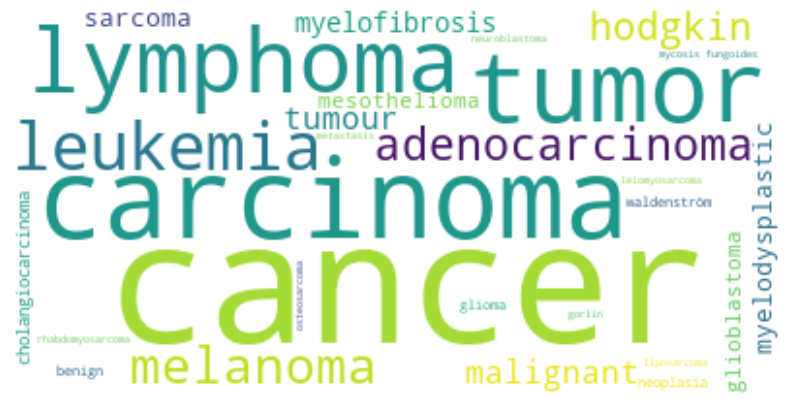

In [277]:
# Preprocess the word labels by removing the "dummy_" part
word_labels = column_totals.index.str.replace('dummy_', '')

# Create a dictionary of word labels and their corresponding counts
word_dict = dict(zip(word_labels, column_totals.values))

# Generate the word cloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Most Frequent terms for Cancer')

# Save the chart as an image file
plt.savefig('/project/charts_uk_and_other/cancer_wordcloud.png', dpi=300)

plt.show()

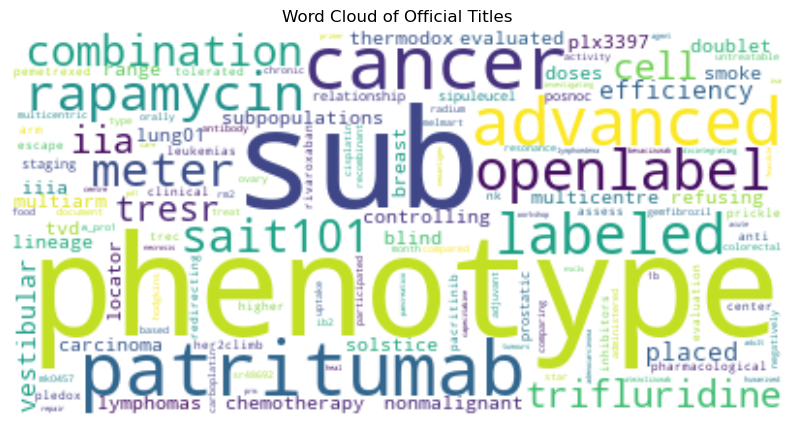

In [278]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

# Create a copy of the dataframe with only the relevant column
df_text = cancer_df[['official_title']].copy()

# Replace missing values with empty strings
df_text['official_title'].fillna('', inplace=True)

# Perform TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_text['official_title'])

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Remove irrelevant words
irrelevant_words = ['study', 'phase', 'randomized', 'controlled', 'trial']
feature_names = [word for word in feature_names if word not in irrelevant_words]

# Calculate the TF-IDF scores for each word
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)

# Create a dictionary of word frequencies
word_frequencies = dict(zip(feature_names, tfidf_scores))

# Create a word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Official Titles')
plt.show()